# Итоговый проект по ML

## Выполняли

Ионко Кирилл Олегович \
Уваров Кирилл Константинович \
Ластухин Михаил Артемович \
Яшенков Михаил Алексеевич

## Мотивация

Про датасет и таргет \
Наша команда выбрала датасет [NBA](https://www.kaggle.com/datasets/nathanlauga/nba-games)
Цель мы поставили так: "Мы хотим предсказывать победу команды, основываясь на статистике игроков в прошлом".


## Подготовка

### Импорт необходимых библиотек

In [3]:
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold,cross_val_score
from sklearn.neighbors import LocalOutlierFactor,NearestNeighbors
from sklearn.preprocessing import LabelEncoder,StandardScaler


### Загрузка датасета

In [4]:
games_df = pd.read_csv('data/games.csv')
players_df = pd.read_csv('data/players.csv')
ranking_df = pd.read_csv('data/ranking.csv')
teams_df = pd.read_csv('data/teams.csv')
games_details_df = pd.read_csv('data/games_details.csv')

/var/folders/nw/kw6j137x7cb70zx_2qbrmfxh0000gn/T/ipykernel_35342/1604028391.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details_df = pd.read_csv('data/games_details.csv')


### Загрузка датасета

## Первый чекпоинт

### EDA

In [5]:
print("Games DataFrame Info:")
print(games_df.info())
print("\nGames Info DataFrame Info:")
print(games_details_df.info())

Games DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float64
 9   FT_PCT_home       26552 non-null  float64
 10  FG3_PCT_home      26552 non-null  float64
 11  AST_home          26552 non-null  float64
 12  REB_home          26552 non-null  float64
 13  TEAM_ID_away      26651 non-null  int64  
 14  PTS_away          26552 non-null  float64
 15  FG_PCT_away       26552 non-null  float64
 16  FT_PCT_away       

In [6]:
print("\nMissing values in games_df:")
print(games_df.isnull().sum())
print("\nMissing values in games_info_df:")
print(games_details_df.isnull().sum())


Missing values in games_df:
GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

Missing values in games_info_df:
GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             615591
START_POSITION       412863
COMMENT              558939
MIN                  109690
FGM                  109690
FGA                  109690
FG_PCT               109690
FG3M                 109690
FG3A                 109690
FG3_PCT              

In [7]:
print("\nGames statistics:")
games_df[["PTS_home", "FG_PCT_home", "FT_PCT_home", "FG3_PCT_home",
          "AST_home", "REB_home", "TEAM_ID_away", "PTS_away", "FG_PCT_away",
          "FT_PCT_away", "FG3_PCT_away", "AST_away", "REB_away", "HOME_TEAM_WINS"]].describe()


Games statistics:


PTS_home   FG_PCT_home   FT_PCT_home  FG3_PCT_home      AST_home  \
count  26552.000000  26552.000000  26552.000000  26552.000000  26552.000000   
mean     103.455898      0.460735      0.760377      0.356023     22.823441   
std       13.283370      0.056676      0.100677      0.111164      5.193308   
min       36.000000      0.250000      0.143000      0.000000      6.000000   
25%       94.000000      0.422000      0.697000      0.286000     19.000000   
50%      103.000000      0.460000      0.765000      0.357000     23.000000   
75%      112.000000      0.500000      0.833000      0.429000     26.000000   
max      168.000000      0.684000      1.000000      1.000000     50.000000   

           REB_home  TEAM_ID_away      PTS_away   FG_PCT_away   FT_PCT_away  \
count  26552.000000  2.665100e+04  26552.000000  26552.000000  26552.000000   
mean      43.374284  1.610613e+09    100.639876      0.449732      0.758816   
std        6.625769  8.659299e+00     13.435868      0.055551      0.103429   
min       15.000000  1.610613e+09     33.000000      0.244000      0.143000   
25%       39.000000  1.610613e+09     91.000000      0.412000      0.692000   
50%       43.000000  1.610613e+09    100.000000      0.449000      0.765000   
75%       48.000000  1.610613e+09    110.000000      0.487000      0.833000   
max       72.000000  1.610613e+09    168.000000      0.687000      1.000000   

       FG3_PCT_away      AST_away      REB_away  HOME_TEAM_WINS  
count  26552.000000  26552.000000  26552.000000    26651.000000  
mean       0.349489     21.496271     42.113249        0.587032  
std        0.109441      5.160596      6.533039        0.492376  
min        0.000000      4.000000     19.000000        0.000000  
25%        0.278000     18.000000     38.000000        0.000000  
50%        0.350000     21.000000     42.000000        1.000000  
75%        0.419000     25.000000     46.000000        1.000000  
max        1.000000     46.000000     81.000000        1.000000

In [8]:
# Разобьем дату
temp_games_df = games_df.copy()
temp_games_df["GAME_DATE_EST"] = pd.to_datetime(games_df["GAME_DATE_EST"])
temp_games_df["year"] = temp_games_df["GAME_DATE_EST"].dt.year
temp_games_df["month"] = temp_games_df["GAME_DATE_EST"].dt.month

In [9]:
games_df[games_df["SEASON"] == 2019]

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
3180     2020-10-11  41900406            Final    1610612748       1610612747   
3181     2020-10-09  41900405            Final    1610612747       1610612748   
3182     2020-10-06  41900404            Final    1610612748       1610612747   
3183     2020-10-04  41900403            Final    1610612748       1610612747   
3184     2020-10-02  41900402            Final    1610612747       1610612748   
...             ...       ...              ...           ...              ...   
19647    2019-10-05  11900005            Final    1610612754       1610612758   
19648    2019-10-05  11900006            Final    1610612744       1610612747   
19649    2019-10-05  11900007            Final    1610612759       1610612753   
19650    2019-10-04  11900002            Final    1610612746       1610612745   
19651    2019-10-04  11900003            Final    1610612758       1610612754   

       SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
3180     2019    1610612748      93.0        0.443        0.591  ...   
3181     2019    1610612747     108.0        0.463        0.857  ...   
3182     2019    1610612748      96.0        0.427        0.808  ...   
3183     2019    1610612748     115.0        0.513        0.913  ...   
3184     2019    1610612747     124.0        0.505        0.588  ...   
...       ...           ...       ...          ...          ...  ...   
19647    2019    1610612754     130.0        0.521        0.944  ...   
19648    2019    1610612744     101.0        0.393        0.769  ...   
19649    2019    1610612759      89.0        0.388        0.750  ...   
19650    2019    1610612746      96.0        0.384        0.600  ...   
19651    2019    1610612758     131.0        0.494        0.778  ...   

       AST_home  REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  \
3180       25.0      41.0    1610612747     106.0        0.483        0.643   
3181       21.0      41.0    1610612748     111.0        0.458        0.955   
3182       18.0      39.0    1610612747     102.0        0.443        0.857   
3183       25.0      37.0    1610612747     104.0        0.430        0.759   
3184       32.0      44.0    1610612748     114.0        0.507        0.912   
...         ...       ...           ...       ...          ...          ...   
19647      35.0      51.0    1610612758     106.0        0.378        0.780   
19648      20.0      47.0    1610612747     123.0        0.475        0.633   
19649      22.0      40.0    1610612753     125.0        0.526        0.714   
19650      26.0      49.0    1610612745     109.0        0.375        0.800   
19651      30.0      30.0    1610612754     132.0        0.516        0.788   

       FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  
3180          0.314      23.0      46.0               0  
3181          0.424      26.0      35.0               0  
3182          0.359      25.0      42.0               0  
3183          0.333      23.0      43.0               1  
3184          0.407      29.0      37.0               1  
...             ...       ...       ...             ...  
19647         0.353      24.0      35.0               1  
19648         0.303      32.0      58.0               0  
19649         0.361      29.0      47.0               0  
19650         0.229      21.0      52.0               0  
19651         0.370      26.0      47.0               0  

[1241 rows x 21 columns]

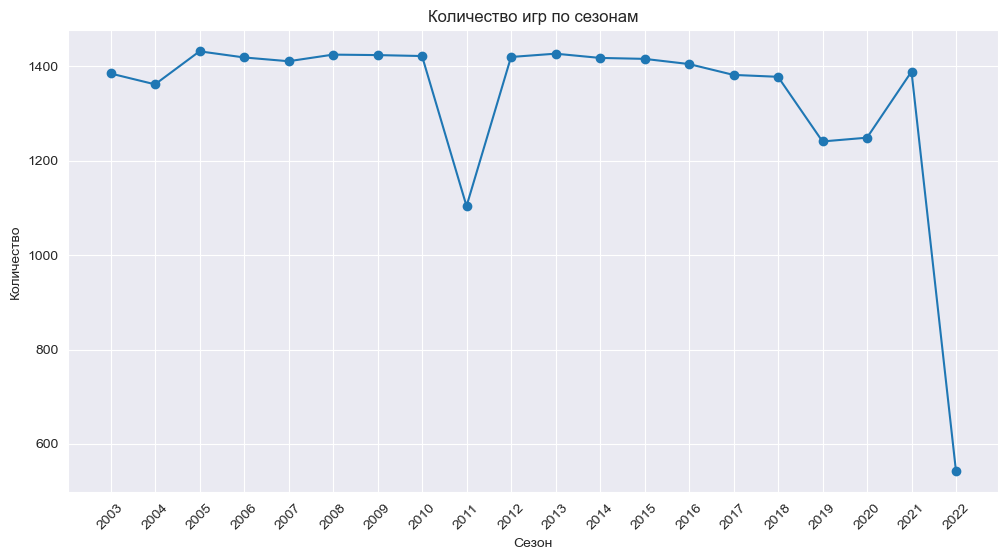

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sorted(games_df["SEASON"].unique()), games_df.groupby('SEASON').count()['GAME_ID'], marker='o')
plt.xticks(ticks=sorted(games_df["SEASON"].unique()), rotation=45)
plt.title("Количество игр по сезонам")
plt.xlabel("Сезон")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

Видно просадка:
- в 2011 году было мало матчей из-за локаута, вызванного разногласиями между игроками и владельцами клубов по поводу нового коллективного трудового соглашения.
- Вторая просадка начинается с 2019 года и длится до 2021. Мы связываем это с COVID
Также можно заметить резкое падение в 2022. Это связано с тем, что датасет обрезан в 2022 попало очень мало игр

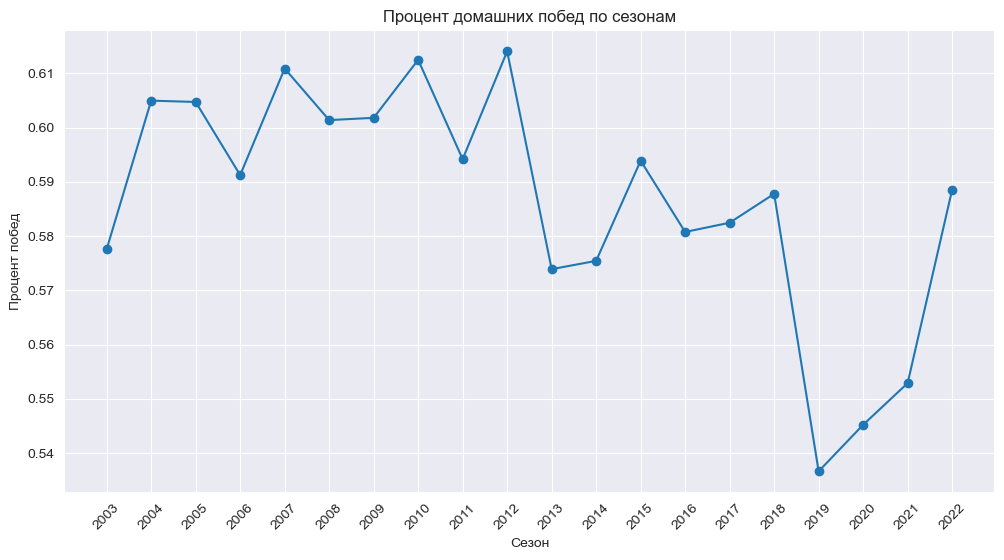

In [11]:
home_wins_pct = games_df['HOME_TEAM_WINS'].mean() * 100

home_wins_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()
plt.figure(figsize=(12, 6))
home_wins_by_season.plot(kind='line', marker='o')
plt.title('Процент домашних побед по сезонам')
plt.ylabel('Процент побед')
plt.xlabel('Сезон')
plt.xticks(ticks=sorted(games_df["SEASON"].unique()), rotation=45)
plt.grid(True)
plt.show()

По этому графику видно, что домашняя команда всегда побеждает чаще, чем гостевая, значит это важная фича

In [12]:
comparison_stats = {
    'Очки': [games_df['PTS_home'].mean(), games_df['PTS_away'].mean()],
    'Процент попаданий': [games_df['FG_PCT_home'].mean(), games_df['FG_PCT_away'].mean()],
    'Подборы': [games_df['REB_home'].mean(), games_df['REB_away'].mean()],
    'Передачи': [games_df['AST_home'].mean(), games_df['AST_away'].mean()]
}

comparison_df = pd.DataFrame(comparison_stats, index=['Дома', 'В гостях'])
print("Сравнение домашней и гостевой статистики:")
print(comparison_df.round(2))

Сравнение домашней и гостевой статистики:
            Очки  Процент попаданий  Подборы  Передачи
Дома      103.46               0.46    43.37     22.82
В гостях  100.64               0.45    42.11     21.50


In [13]:

home_stats = games_df.groupby('TEAM_ID_home').agg({
    'PTS_home': 'mean',
    'FG_PCT_home': 'mean',
    'REB_home': 'mean',
    'AST_home': 'mean',
    'HOME_TEAM_WINS': 'mean'
}).round(2)

home_stats = home_stats.merge(
    teams_df[['TEAM_ID', 'NICKNAME', 'CITY', 'ABBREVIATION']],
    left_index=True,
    right_on='TEAM_ID',
    how='left'
)

top_home_scoring = home_stats.nlargest(10, 'PTS_home')
print("Топ-10 команд по очкам дома:")
print(top_home_scoring[['CITY', 'NICKNAME', 'PTS_home', 'FG_PCT_home', 'HOME_TEAM_WINS']])

Топ-10 команд по очкам дома:
             CITY   NICKNAME  PTS_home  FG_PCT_home  HOME_TEAM_WINS
29   Golden State   Warriors    109.54         0.47            0.67
5          Denver    Nuggets    108.63         0.47            0.67
17        Phoenix       Suns    107.71         0.47            0.58
19     Sacramento      Kings    105.31         0.46            0.50
21  Oklahoma City    Thunder    105.26         0.46            0.60
4          Dallas  Mavericks    104.96         0.46            0.65
6         Houston    Rockets    104.73         0.45            0.63
8     Los Angeles     Lakers    104.46         0.46            0.59
22        Toronto    Raptors    104.15         0.46            0.59
10      Milwaukee      Bucks    104.09         0.46            0.58


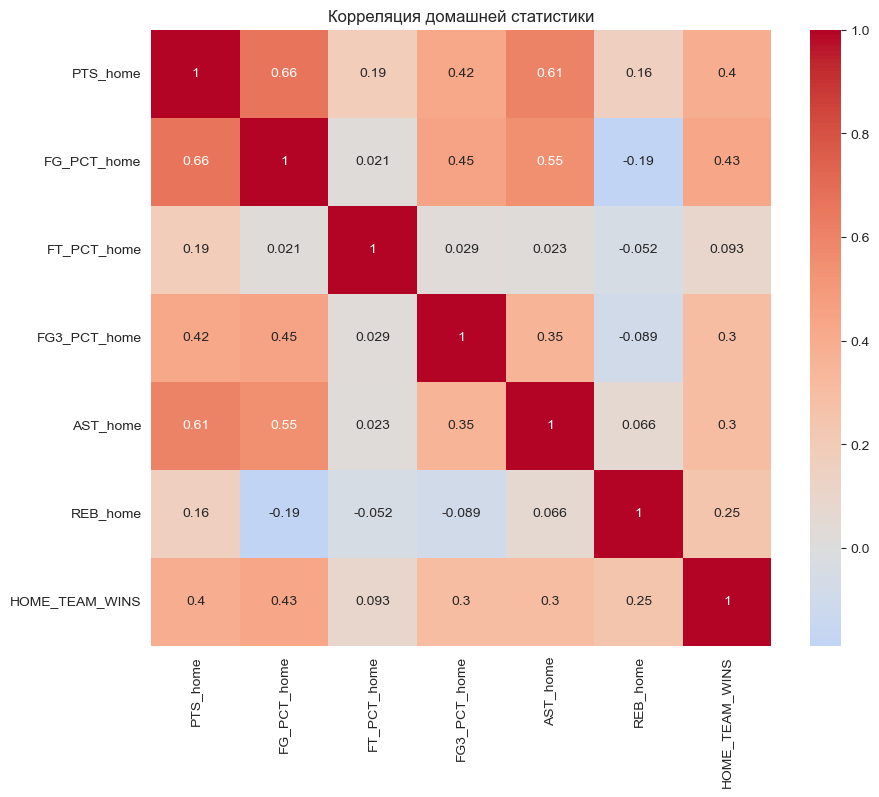

In [14]:
# Посмотрим на корреляцию
home_corr_cols = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home',
                  'AST_home', 'REB_home', 'HOME_TEAM_WINS']
home_corr = games_df[home_corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(home_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция домашней статистики')
plt.show()

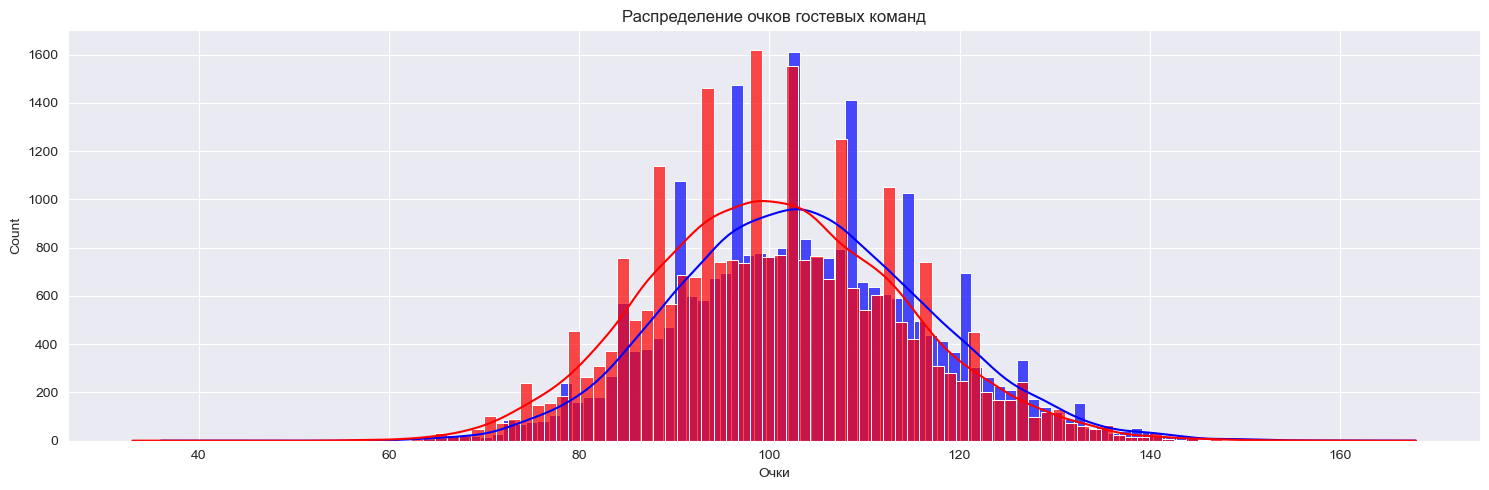

In [15]:
plt.figure(figsize=(15, 5))

sns.histplot(games_df['PTS_home'], kde=True, color='blue', alpha=0.7)
sns.histplot(games_df['PTS_away'], kde=True, color='red', alpha=0.7)
plt.title('Распределение очков гостевых команд')
plt.xlabel('Очки')
plt.tight_layout()
plt.show()

Распределения почти совпадают, но все же домашняя команда больше

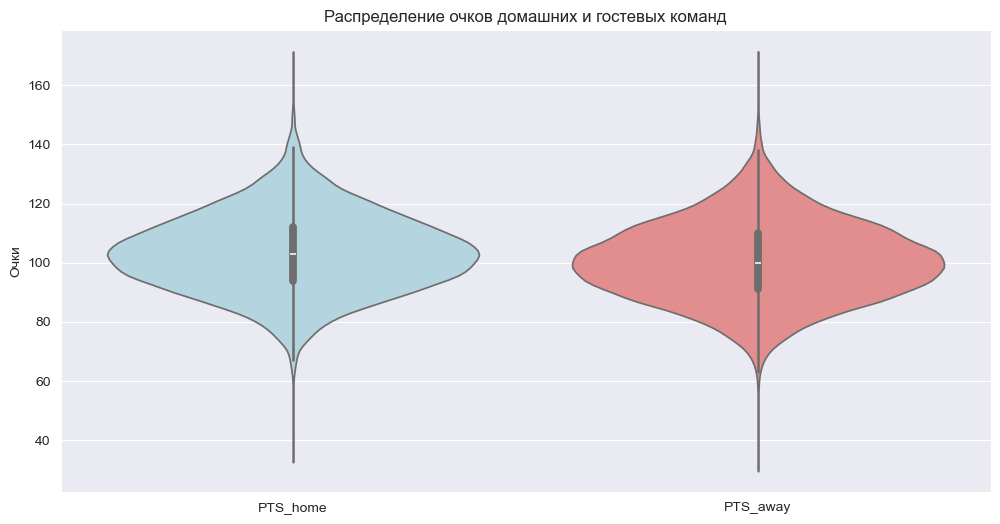

In [16]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=games_df[['PTS_home', 'PTS_away']], palette=['lightblue', 'lightcoral'])
plt.title('Распределение очков домашних и гостевых команд')
plt.ylabel('Очки')
plt.show()

И по этому графику можно лишний раз подтвердить, что в home в среднем больше pts

In [17]:
# Теперь посмотрим на таргет
temp_games_df["HOME_TEAM_WINS"]

0        1
1        1
2        1
3        1
4        0
        ..
26646    1
26647    0
26648    1
26649    1
26650    0
Name: HOME_TEAM_WINS, Length: 26651, dtype: int64

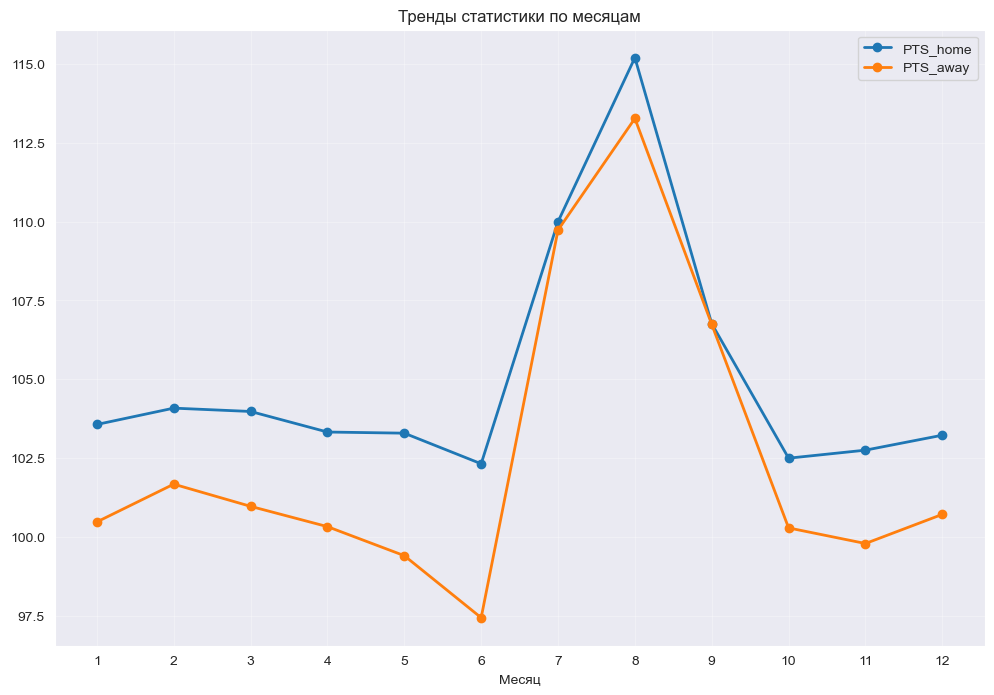

In [18]:
monthly_trends = temp_games_df.groupby('month').agg({
    'PTS_home': 'mean',
    'PTS_away': 'mean'
})

plt.figure(figsize=(12, 8))
for column in monthly_trends.columns:
    plt.plot(monthly_trends.index, monthly_trends[column], marker='o', label=column, linewidth=2)
plt.title('Тренды статистики по месяцам')
plt.xlabel('Месяц')
plt.xticks(ticks=temp_games_df['month'].unique())
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Тут тоже видно, что Home всегда выше

In [19]:
# Описание кратких статистик
games_df['point_difference'] = abs(games_df['PTS_home'] - games_df['PTS_away'])
close_games = games_df[games_df['point_difference'] <= 3]

print(f"Всего игр: {len(games_df)}")
print(f"Close games (разница ≤ 3 очка): {len(close_games)}")
print(f"Процент close games: {len(close_games) / len(games_df) * 100:.2f}%")

close_home_wins = close_games['HOME_TEAM_WINS'].mean() * 100
print(f"Процент домашних побед в close games: {close_home_wins:.2f}%")

Всего игр: 26651
Close games (разница ≤ 3 очка): 4074
Процент close games: 15.29%
Процент домашних побед в close games: 52.26%


#### Вывод по eda
- Фактор игры на домашней арене играет важную роль.
- Игры в годах распределены неравномерно
- Игры в сезонах распределены неравномерно
- При обучении модели следует кумулятивно считать среднее прошлых годов для лучшего предсказания

### Препроцессинг

В итоге для Baseline было решено использовать следующие фичи(помимо таргета):
  1. **home_WR_last_season & away_WR_last_season**  - процент побед команды в предыдущем сезоне. Считается как (кол-во побед в прошлом сезоне / всего игр) в прошлом сезоне

 2. **home_avg_plus_minus_pre & away_avg_plus_minus_pre** - cредняя разница очков команды во всех предыдущих матчах. Это более точный показатель силы, чем просто победы/поражения

3. **home_comments_last3 & away_comments_last3**- кол-во комментариев к игрокам команды за последние 3 игры. Идея в том, что комментарии часто указывают на травмы, замены, особые обстоятельства. Значит чем больше комментариев - тем больше нестандартности в команде, а значит может быть какая-то нестабильность(а может это наоборот, отвлекает модель, мы пока сами не уверены)
4. **GAME_DATE_EST** - дата для разделения на train/test(мы же хотим предсказывать будущее)

### Куча неинтересных преобразований

In [20]:
# Переводим дату и мержим teams_df в games_df
games_df["GAME_DATE_EST"] = pd.to_datetime(games_df["GAME_DATE_EST"])

games = games_df.merge(
    teams_df[["TEAM_ID", "ARENA"]].rename(columns={
        "TEAM_ID": "HOME_TEAM_ID",
        "ARENA": "home_arena"
    }),
    how="left",
    on="HOME_TEAM_ID"
)

In [21]:
# Приводим SEASON_ID (22015 → 2015)
ranking_df["season_clean"] = ranking_df["SEASON_ID"] % 10000


In [22]:
# Считаем WR по сезону
wr = (
    ranking_df.groupby(["TEAM_ID", "season_clean"])["W_PCT"]
    .mean()
    .reset_index()
)

wr.columns = ["TEAM_ID", "SEASON_SRC", "WR_last_season"]

wr["SEASON"] = wr["SEASON_SRC"] + 1


In [23]:
# Мержим WR, избегая конфликтов с названиями столбцов
games = games.merge(
    wr.rename(columns={"TEAM_ID": "HOME_TEAM_ID"}),
    how="left",
    on=["HOME_TEAM_ID", "SEASON"]
)

games = games.rename(columns={"WR_last_season": "home_WR_last_season"})



In [24]:
# AWAY - то же самое
games = games.merge(
    wr.rename(columns={"TEAM_ID": "VISITOR_TEAM_ID"}),
    how="left",
    on=["VISITOR_TEAM_ID", "SEASON"]
)

games = games.rename(columns={"WR_last_season": "away_WR_last_season"})


In [25]:
# Чистим тех. колонки
games = games.drop(columns=["SEASON_SRC"], errors="ignore")



In [26]:
# Средний Плюс/Минус для команд по истории
team_pm = (
    games_details_df.groupby(["GAME_ID", "TEAM_ID"])["PLUS_MINUS"]
    .mean()
    .reset_index()
    .rename(columns={"PLUS_MINUS": "avg_plus_minus"})
)

games = games.merge(
    team_pm.rename(columns={"TEAM_ID": "HOME_TEAM_ID", "avg_plus_minus": "home_plus_minus"}),
    on=["GAME_ID", "HOME_TEAM_ID"],
    how="left"
)

games = games.merge(
    team_pm.rename(columns={"TEAM_ID": "VISITOR_TEAM_ID", "avg_plus_minus": "away_plus_minus"}),
    on=["GAME_ID", "VISITOR_TEAM_ID"],
    how="left"
)

games = games.sort_values("GAME_DATE_EST")

games["home_avg_plus_minus_pre"] = (
    games.groupby("HOME_TEAM_ID")["home_plus_minus"]
    .transform(lambda x: x.shift().expanding().mean())
)

games["away_avg_plus_minus_pre"] = (
    games.groupby("VISITOR_TEAM_ID")["away_plus_minus"]
    .transform(lambda x: x.shift().expanding().mean())
)


In [27]:
comment_count = (
    games_details_df.groupby(["GAME_ID", "TEAM_ID"])["COMMENT"]
    .apply(lambda x: x.notna().sum())
    .reset_index()
    .rename(columns={"COMMENT": "comment_count"})
)

# HOME
games = games.merge(
    comment_count.rename(columns={"TEAM_ID": "HOME_TEAM_ID", "comment_count": "home_comment_count"}),
    on=["GAME_ID", "HOME_TEAM_ID"],
    how="left"
)

# AWAY
games = games.merge(
    comment_count.rename(columns={"TEAM_ID": "VISITOR_TEAM_ID", "comment_count": "away_comment_count"}),
    on=["GAME_ID", "VISITOR_TEAM_ID"],
    how="left"
)

games["home_comments_last3"] = (
    games.groupby("HOME_TEAM_ID")["home_comment_count"]
    .transform(lambda x: x.shift().rolling(3, min_periods=1).sum())
)

games["away_comments_last3"] = (
    games.groupby("VISITOR_TEAM_ID")["away_comment_count"]
    .transform(lambda x: x.shift().rolling(3, min_periods=1).sum())
)

In [28]:
baseline_df = games[[
    "GAME_DATE_EST",
    "home_WR_last_season", "away_WR_last_season",
    "home_avg_plus_minus_pre", "away_avg_plus_minus_pre",
    "home_comments_last3", "away_comments_last3",
    "HOME_TEAM_WINS"
]]

### Готовый датасет для Baseline

In [29]:
baseline_df

GAME_DATE_EST  home_WR_last_season  away_WR_last_season  \
0        2003-10-05             0.573000             0.732000   
1        2003-10-06             0.341000             0.512000   
2        2003-10-07             0.451000             0.451000   
3        2003-10-07             0.720000             0.329000   
4        2003-10-07             0.610000             0.524000   
...             ...                  ...                  ...   
26646    2022-12-21             0.574030             0.326467   
26647    2022-12-21             0.491627             0.623011   
26648    2022-12-21             0.597848             0.255945   
26649    2022-12-22             0.619619             0.462514   
26650    2022-12-22             0.372221             0.398909   

       home_avg_plus_minus_pre  away_avg_plus_minus_pre  home_comments_last3  \
0                          NaN                      NaN                  NaN   
1                          NaN                      NaN                  NaN   
2                          NaN                      NaN                  NaN   
3                          NaN                      NaN                  NaN   
4                          NaN                      NaN                  NaN   
...                        ...                      ...                  ...   
26646                 1.996147                -1.136991                 12.0   
26647                 0.696136                -1.142517                 13.0   
26648                 0.601354                -1.410236                  4.0   
26649                 2.337891                -2.372159                  6.0   
26650                 0.587396                 0.614851                  9.0   

       away_comments_last3  HOME_TEAM_WINS  
0                      NaN               1  
1                      NaN               1  
2                      NaN               1  
3                      NaN               1  
4                      NaN               1  
...                    ...             ...  
26646                  9.0               0  
26647                  5.0               0  
26648                  7.0               1  
26649                 10.0               1  
26650                  5.0               1  

[26651 rows x 8 columns]

### Baseline

В качестве Baseline разделим датасет по времени, обучим лог регрессию и посчитаем ROC-AUC

In [30]:
# Разделяем датасет

# Предварительно избавляемся от na(в тупую, потому что NaN там только у столбцов, где нет предыдущего сезона/игр для подсчета статистик(примерно 100 пустых на 26 тысяч строк)
cleaned_baseline_df = baseline_df.dropna()
cleaned_baseline_df = cleaned_baseline_df.sort_values("GAME_DATE_EST")

# Для разделения по времени train/test : 4/1
split_idx = int(len(baseline_df) * 0.8)

train = cleaned_baseline_df.iloc[:split_idx]
test = cleaned_baseline_df.iloc[split_idx:]

X_train = train.drop(["GAME_DATE_EST", "HOME_TEAM_WINS"], axis=1)
y_train = train["HOME_TEAM_WINS"]

X_test = test.drop(["GAME_DATE_EST", "HOME_TEAM_WINS"], axis=1)
y_test = test["HOME_TEAM_WINS"]

In [31]:
# Хотя бы как-то скалируем на baseline
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Обучение и Результаты

In [32]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("ROC-AUC:", round(auc, 4))

ROC-AUC: 0.6011


![ВСЕ!](https://foni.papik.pro/uploads/posts/2024-10/foni-papik-pro-13xn-p-kartinki-yeralash-vse-na-prozrachnom-fone-4.png)

## Второй чекпоинт

### Анализ аномалий

Ниже список фичей, которые будут подвергнуты анализу на аномалии. Отбросили все id, даты, текст(города) и бинарные(в частности таргет)
1. **PTS_home** *(games_df)* - выявляет аномальные матчи с экстремальными счётами (blowouts, OT).

2. **PTS_away** *(games_df)* - то же самое для гостей.

3. **FG_PCT_home** *(games_df)* - сверхнизкие/сверхвысокие значения указывают на аномальные игровые условия.

4. **FG_PCT_away** *(games_df)* - аналогично для гостей.

5. **FT_PCT_home** *(games_df)* - необычно низкий процент штрафных может указывать на сбой данных или травмы.

6. **FT_PCT_away** *(games_df)* - аналогично.

7. **FG3_PCT_home** *(games_df)* - броски из трёх могут показывать редкие игры со сверхпопаданием или провалом.

8. **FG3_PCT_away** *(games_df)* - аналогично.

9. **AST_home** *(games_df)* - аномально низкие или высокие ассисты означают сломанный темп или ошибки данных.

10. **AST_away** *(games_df)* - аналогично.

11. **REB_home** *(games_df)* - огромные значения (60+) могут быть выбросом или играми с большим числом промахов.

12. **REB_away** *(games_df)* - аналогично.

13. **MIN** *(games_details_df)* - 0 минут или 48+ минут могут быть ошибками или аномальными случаями.

14. **FG_PCT** *(games_details_df)* - проценты за пределами [0,1] → явная ошибка.

15. **FG3_PCT** *(games_details_df)* - экстремально низкие/высокие значения.

16. **FT_PCT** *(games_details_df)* - необычные показатели штрафных.

17. **PTS** *(games_details_df)* - игроки с 0 в старте или 70+ очков - редкие события/аномалии.

18. **REB** *(games_details_df)* - большие всплески (20+, 30+) - редкие аномалии.

19. **AST** *(games_details_df)* - слишком высокие показатели (20+) - выбросы.

20. **STL** *(games_details_df)* - 8–10 перехватов бывают, но редки → выбросы.

21. **BLK** *(games_details_df)* - 7+ блоков - очень редкие случаи.

22. **TO** *(games_details_df)* - слишком много потерь.

23. **PLUS_MINUS** *(games_details_df)* - значение ±30/±40 - нетипично, важно как выброс.

24. **W_PCT** *(ranking_df)* - значения близкие к 0 или 1 могут быть аномальными (непоходовый сезон, ошибки).

25. **W** *(ranking_df)* - количество побед может быть некорректным (слишком много/мало).

26. **L** *(ranking_df)* - аналогично.

27. **G** *(ranking_df)* - команда сыграла подозрительно мало матчей.

28. **home_WR_last_season** *(baseline_df)* - WR = 0 или 1 → выбросы (нетипичные сезоны сравниваемой команды).

29. **away_WR_last_season** *(baseline_df)* - то же самое.

30. **home_avg_plus_minus_pre** *(baseline_df)* - огромный исторический +/− до игры (например +20) → может быть артефакт.

31. **away_avg_plus_minus_pre** *(baseline_df)* - аналогично.

32. **home_comments_last3** *(baseline_df)* - всплеск комментариев может означать травмы, DNP, неполный состав.

33. **away_comments_last3** *(baseline_df)* - аналогично.

34. **ARENACAPACITY** *(teams_df)* - экстремально маленькие/большие арены могут быть выбросами.



Напишем общую функцию для анализа всех фичей

In [33]:
def analyze_outliers(
        df,
        features,
        date_col=None,
        z_thresh=3.0,
        figsize=(15, 5)
):
    sns.set(style="whitegrid")

    # если дата есть, подготовим её
    if date_col and date_col in df.columns:
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    stats = []

    # создаём большое полотно figure
    n = len(features)
    rows = n
    cols = 3 if date_col else 2  # если даты нет - два графика

    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    fig.suptitle("Анализ выбросов по фичам", fontsize=22)
    plt.subplots_adjust(hspace=0.4)

    # делаем axes двумерным даже если только 1 фича
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, feat in enumerate(features):

        if feat not in df.columns:
            print(f"пропуск фичи {feat} - нет в датасете")
            continue

        series = df[feat].dropna()

        if len(series) == 0:
            print(f" пропуск фичи {feat} - пустая колонка")
            continue

        ax = axes[i, 0]
        sns.histplot(series, kde=True, bins=40, ax=ax)
        ax.set_title(f"{feat} - distribution")

        ax = axes[i, 1]
        sns.boxplot(x=series, ax=ax)
        ax.set_title(f"{feat} - boxplot")

        if date_col:
            ax = axes[i, 2]
            ax.scatter(df[date_col], df[feat], alpha=0.4)
            ax.set_title(f"{feat} vs {date_col}")

        z_scores = (series - series.mean()) / (series.std() + 1e-9)
        z_outliers = series[np.abs(z_scores) > z_thresh]

        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        iqr_outliers = series[(series < lower) | (series > upper)]

        stats.append({
            "feature": feat,
            "count": len(series),
            "z_outliers": len(z_outliers),
            "iqr_outliers": len(iqr_outliers),
            "iqr_lower": lower,
            "iqr_upper": upper,
            "mean": series.mean(),
            "std": series.std(),
            "min": series.min(),
            "max": series.max()
        })

    plt.show()

    return pd.DataFrame(stats)


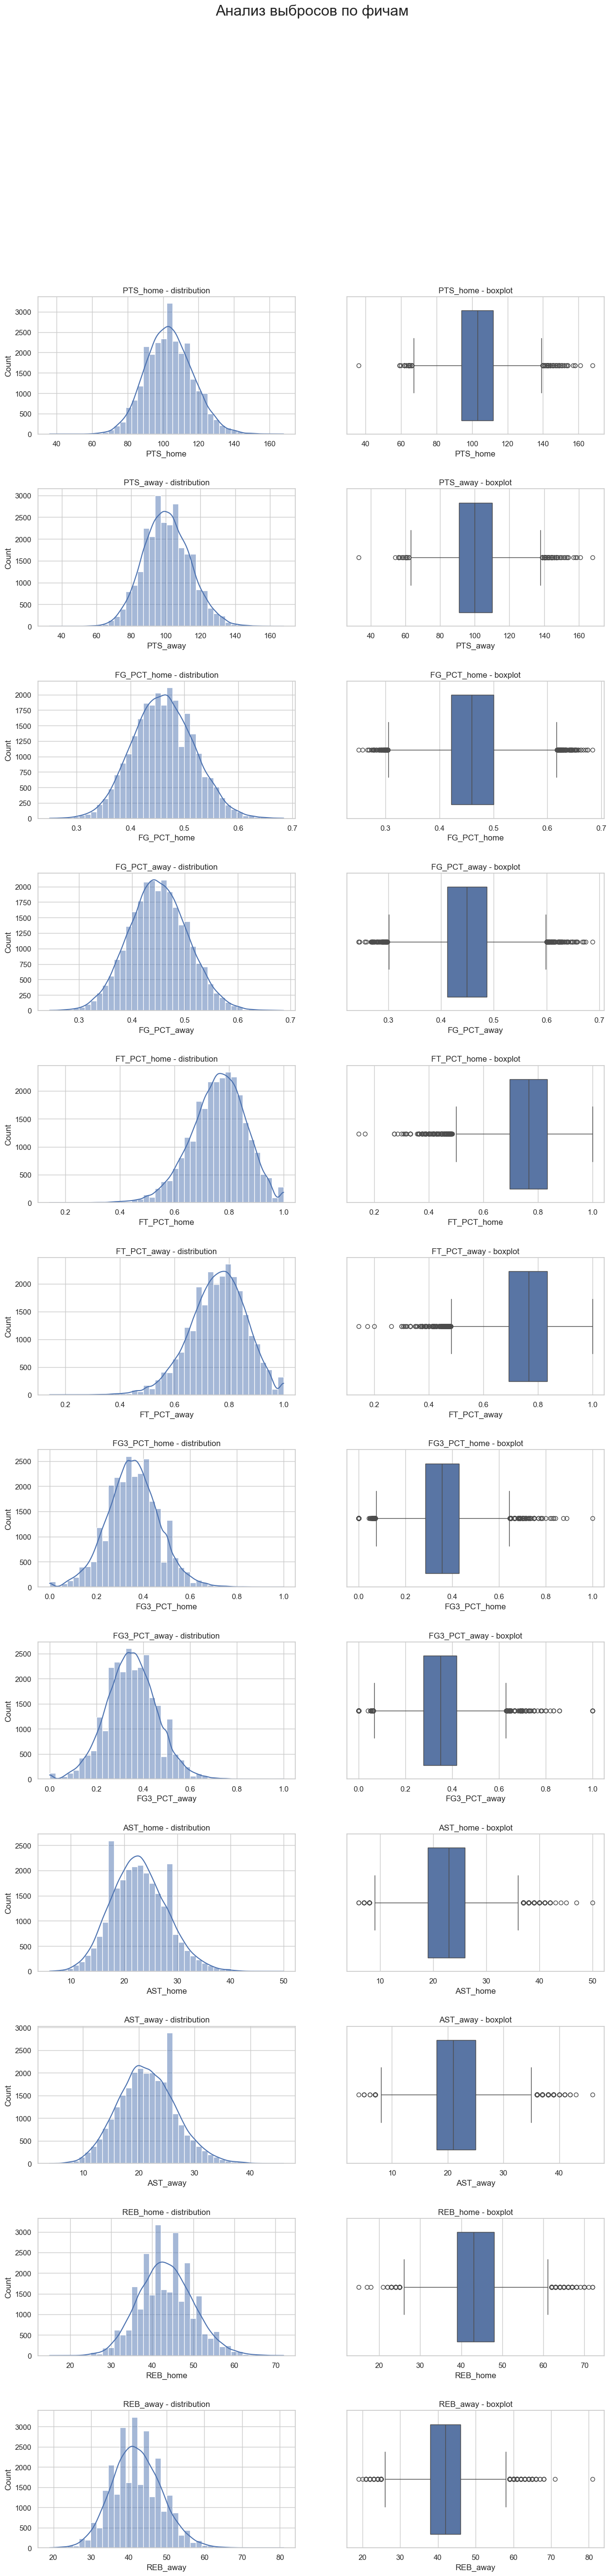

feature  count  z_outliers  iqr_outliers  iqr_lower  iqr_upper  \
0       PTS_home  26552          82           207    67.0000   139.0000   
1       PTS_away  26552          92           134    62.5000   138.5000   
2    FG_PCT_home  26552          68           153     0.3050     0.6170   
3    FG_PCT_away  26552          74           197     0.2995     0.5995   
4    FT_PCT_home  26552         129           209     0.4930     1.0370   
5    FT_PCT_away  26552         126           250     0.4805     1.0445   
6   FG3_PCT_home  26552         189           381     0.0715     0.6435   
7   FG3_PCT_away  26552         194           359     0.0665     0.6305   
8       AST_home  26552          87           215     8.5000    36.5000   
9       AST_away  26552         114           187     7.5000    35.5000   
10      REB_home  26552          82           201    25.5000    61.5000   
11      REB_away  26552          98           349    26.0000    58.0000   

          mean        std     min      max  
0   103.455898  13.283370  36.000  168.000  
1   100.639876  13.435868  33.000  168.000  
2     0.460735   0.056676   0.250    0.684  
3     0.449732   0.055551   0.244    0.687  
4     0.760377   0.100677   0.143    1.000  
5     0.758816   0.103429   0.143    1.000  
6     0.356023   0.111164   0.000    1.000  
7     0.349489   0.109441   0.000    1.000  
8    22.823441   5.193308   6.000   50.000  
9    21.496271   5.160596   4.000   46.000  
10   43.374284   6.625769  15.000   72.000  
11   42.113249   6.533039  19.000   81.000

In [34]:
games_features = [
    "PTS_home", "PTS_away",
    "FG_PCT_home", "FG_PCT_away",
    "FT_PCT_home", "FT_PCT_away",
    "FG3_PCT_home", "FG3_PCT_away",
    "AST_home", "AST_away",
    "REB_home", "REB_away"
]

out_games = analyze_outliers(games_df, games_features)
out_games

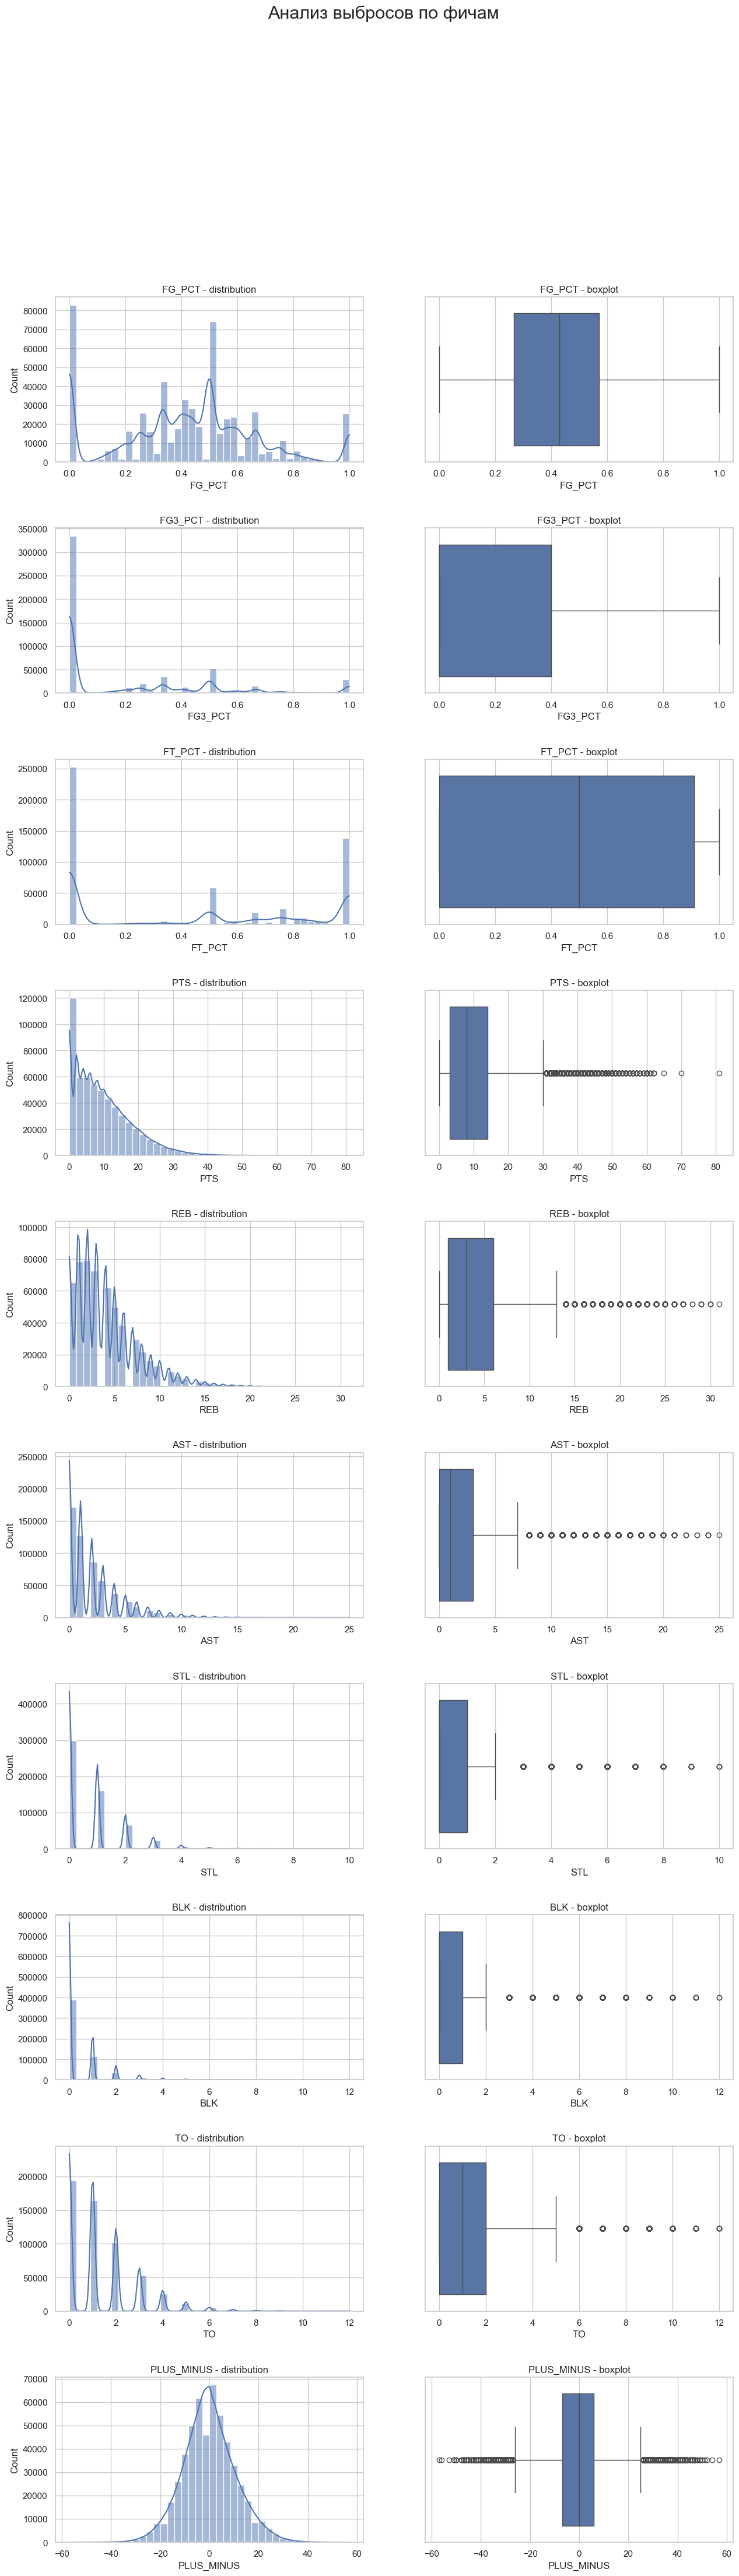

feature   count  z_outliers  iqr_outliers  iqr_lower  iqr_upper  \
0      FG_PCT  558938           0             0    -0.1890     1.0270   
1     FG3_PCT  558938           0             0    -0.6000     1.0000   
2      FT_PCT  558938           0             0    -1.3635     2.2725   
3         PTS  558938        5931         10861   -13.5000    30.5000   
4         REB  558938        7498         11019    -6.5000    13.5000   
5         AST  558938       10859         24446    -4.5000     7.5000   
6         STL  558938        9781         32316    -1.5000     2.5000   
7         BLK  558938        7378         19819    -1.5000     2.5000   
8          TO  558938        7329          7329    -3.0000     5.0000   
9  PLUS_MINUS  535277        2986         11045   -26.5000    25.5000   

       mean        std   min   max  
0  0.416842   0.251913   0.0   1.0  
1  0.201032   0.289685   0.0   1.0  
2  0.435949   0.428166   0.0   1.0  
3  9.688218   8.082152   0.0  81.0  
4  4.058010   3.482500   0.0  31.0  
5  2.103958   2.475476   0.0  25.0  
6  0.721436   0.972231   0.0  10.0  
7  0.460339   0.860962   0.0  12.0  
8  1.320297   1.402329   0.0  12.0  
9 -0.000488  10.665573 -57.0  57.0

In [35]:
details_features = ["FG_PCT", "FG3_PCT", "FT_PCT",
                    "PTS", "REB", "AST", "STL", "BLK", "TO", "PLUS_MINUS"
                    ]

out_details = analyze_outliers(games_details_df, details_features)
out_details

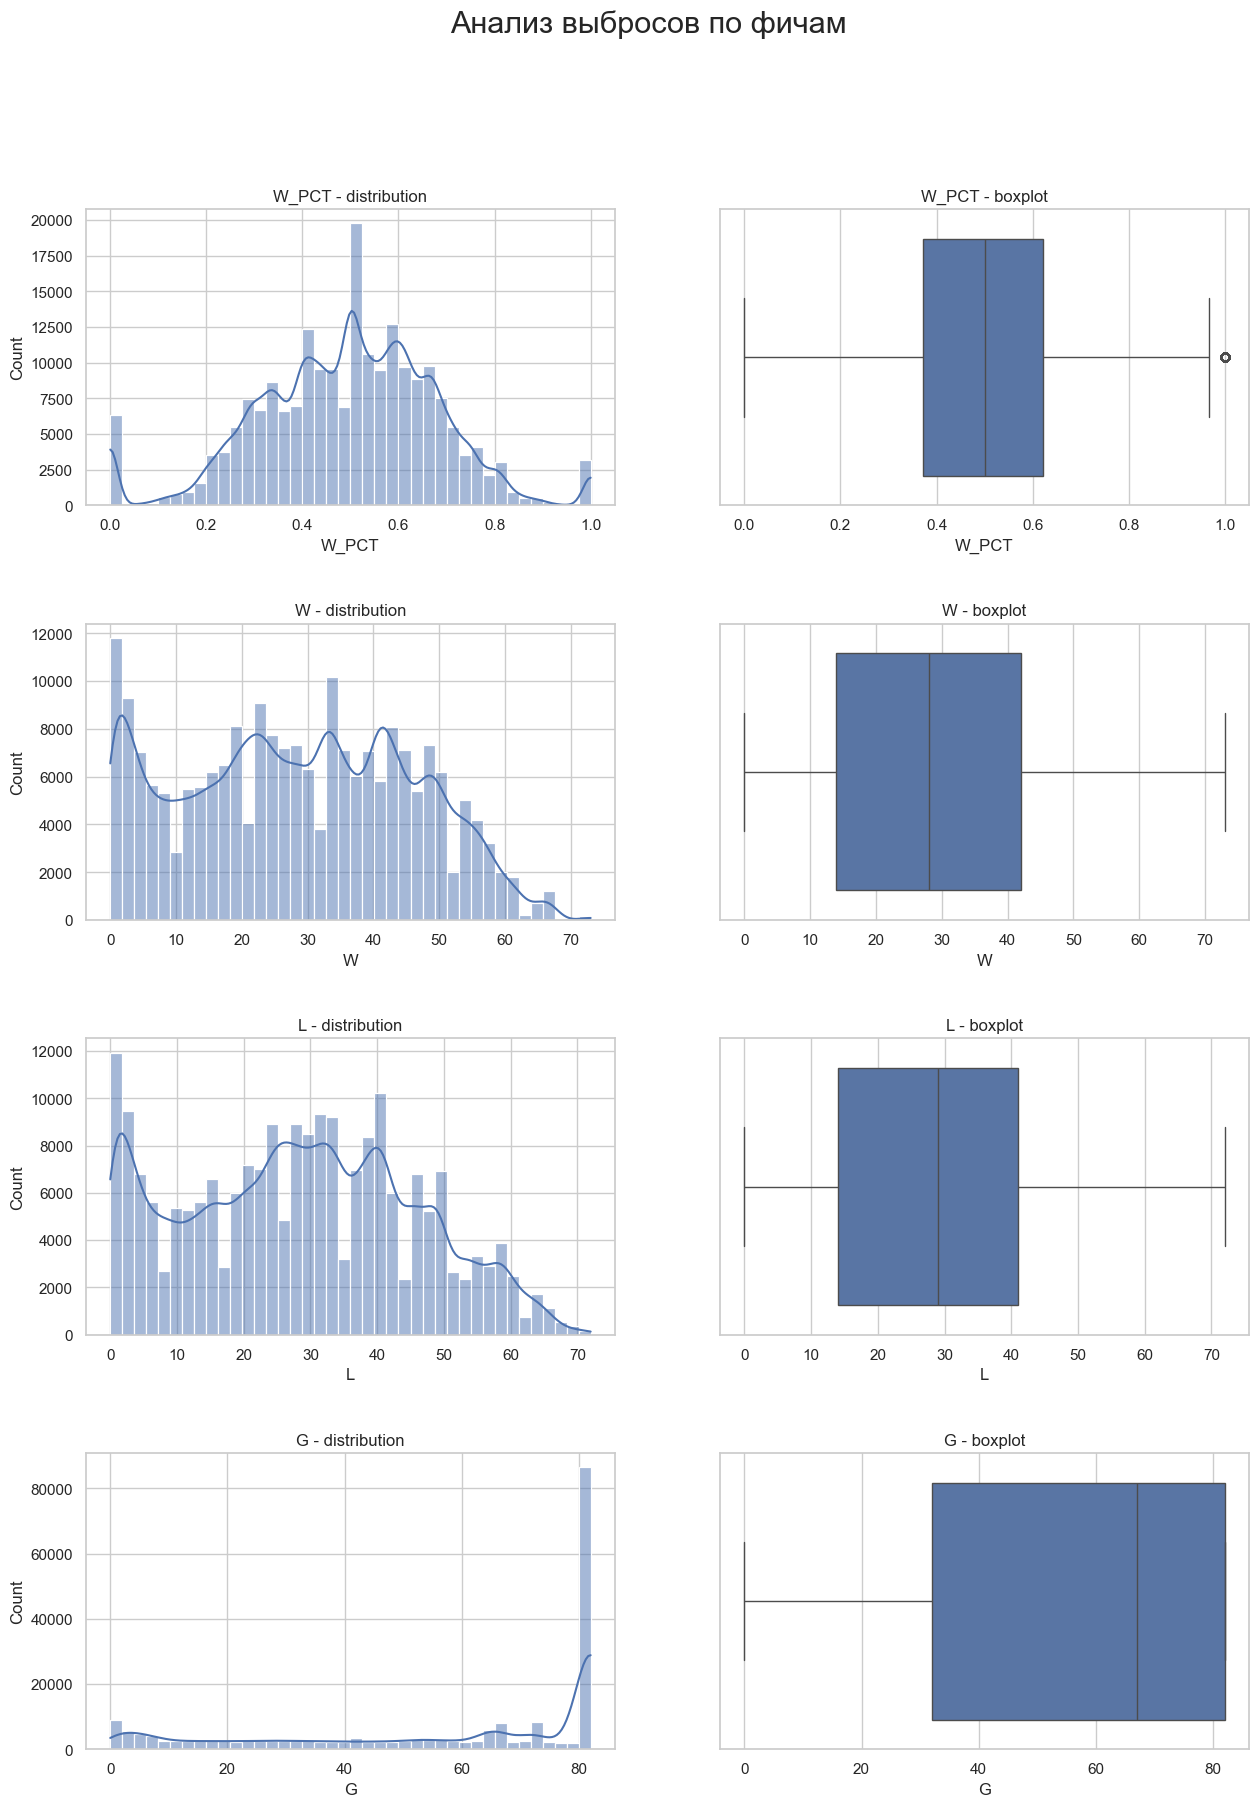

In [36]:
ranking_features = ["W_PCT", "W", "L", "G"]

out_ranking = analyze_outliers(ranking_df, ranking_features)


Заодно проверим фичи, которые сами придумали во время создания Baseline

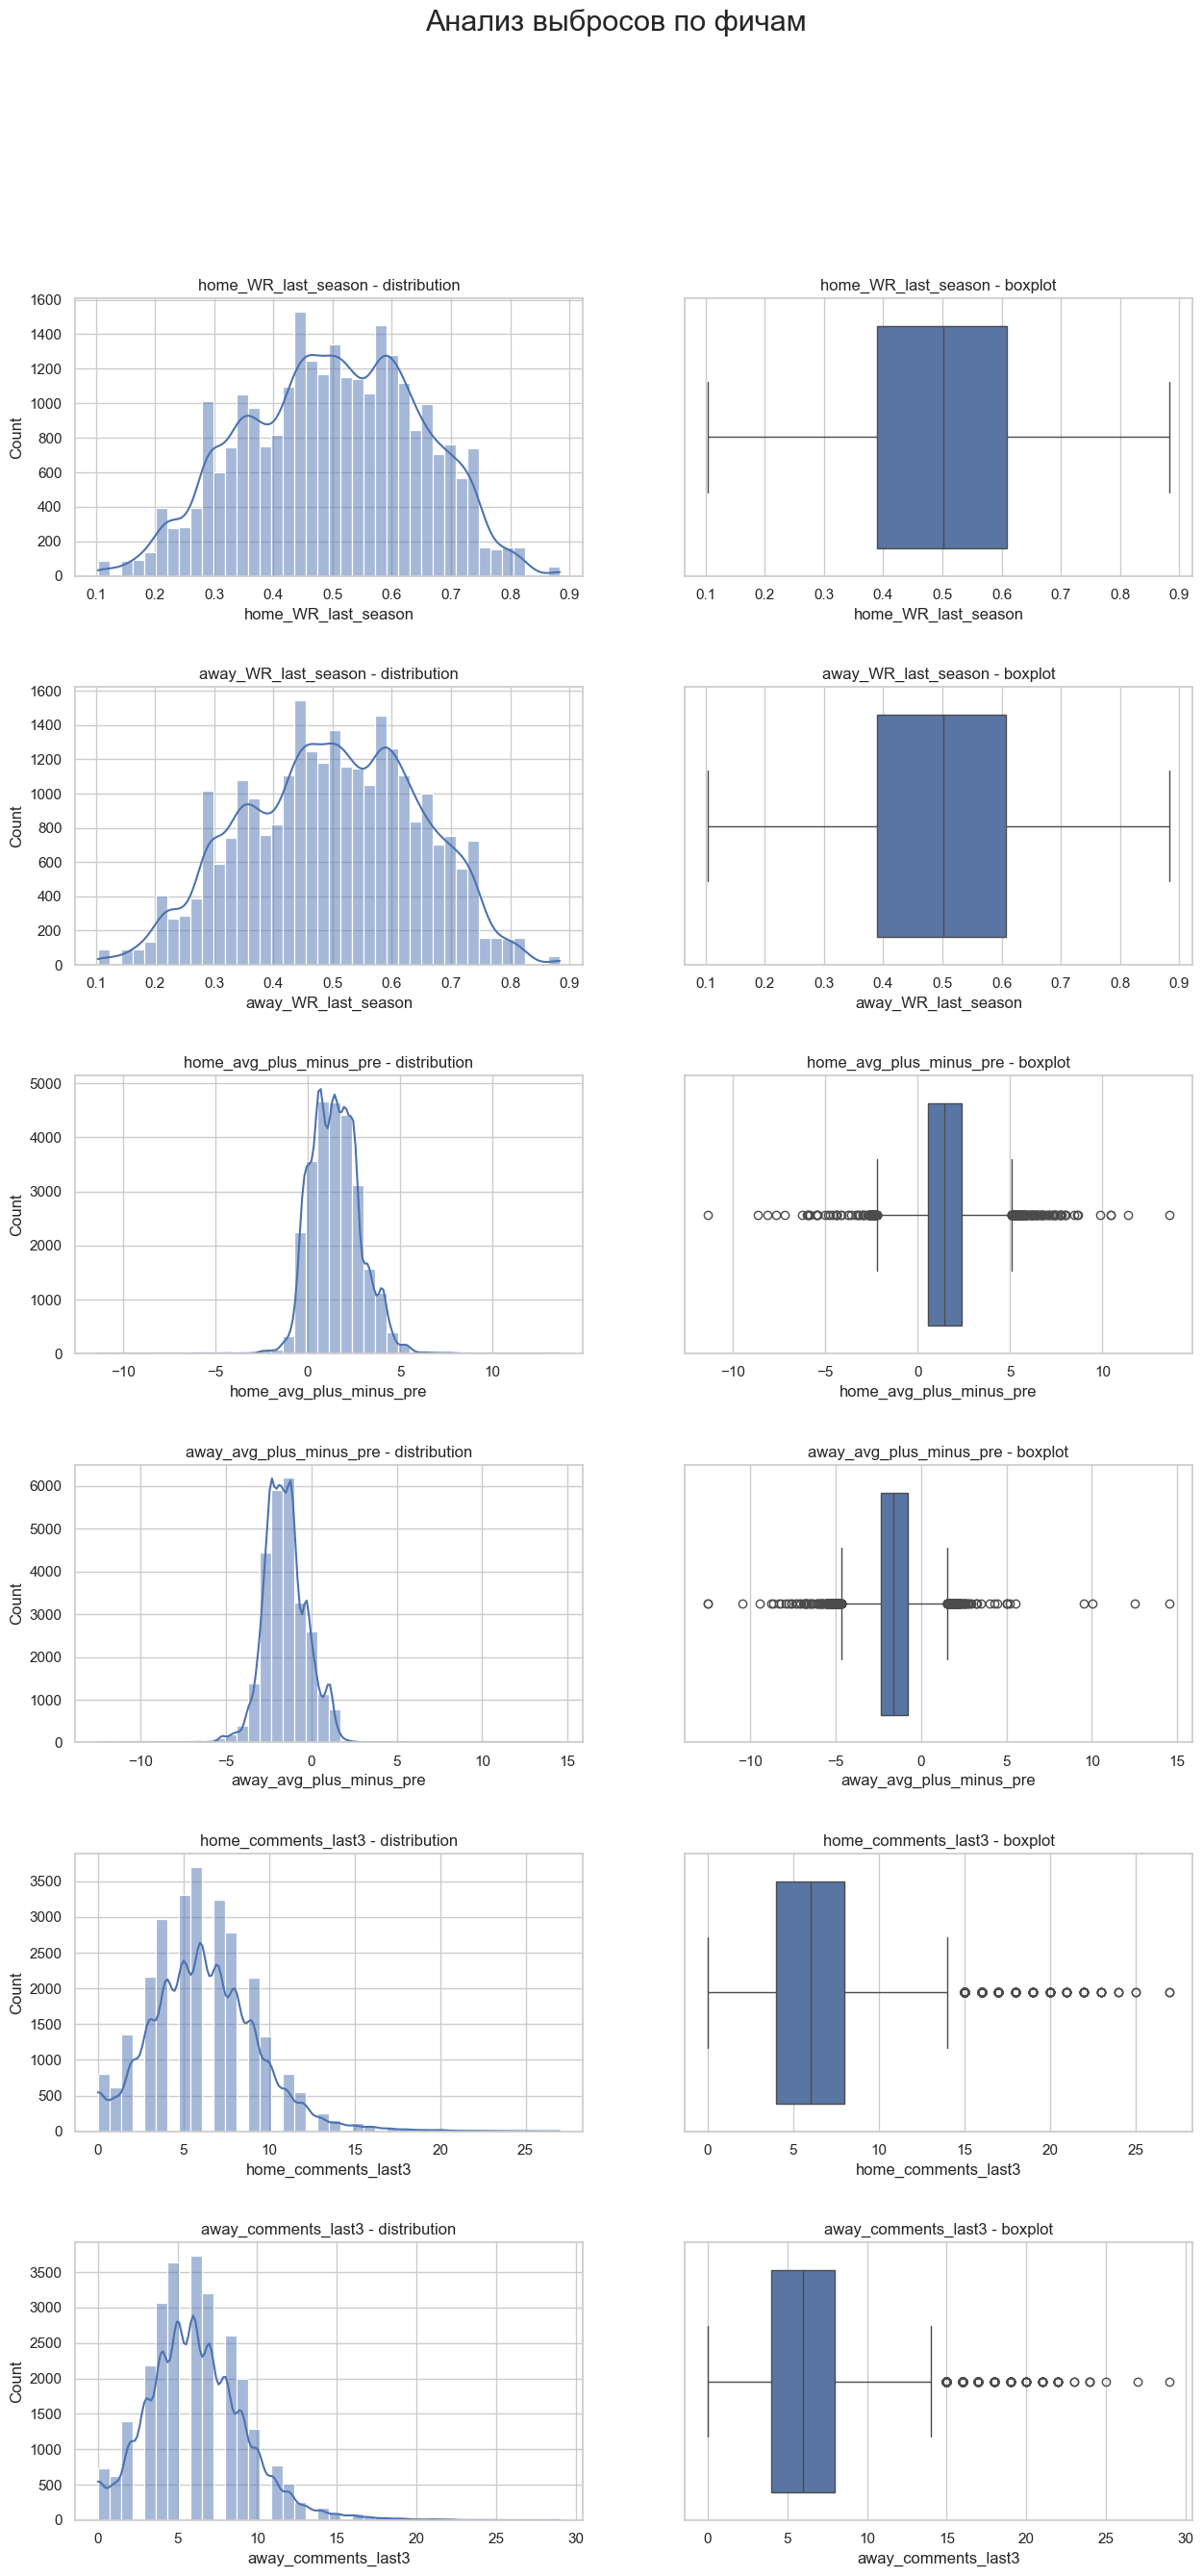

In [37]:
baseline_features = [
    "home_WR_last_season", "away_WR_last_season",
    "home_avg_plus_minus_pre", "away_avg_plus_minus_pre",
    "home_comments_last3", "away_comments_last3"
]

out_baseline = analyze_outliers(baseline_df, baseline_features)


#### Дополнительный анализ: Тест Граббса
Применим статистический тест Граббса, потому что так попросили в ТЗ

In [38]:
def grubbs_test(data, alpha=0.05):
    n = len(data)
    if n < 3:
        return False, None, None, None

    mean = np.mean(data)
    std = np.std(data, ddof=1)

    if std == 0:
        return False, None, None, None

    # Находим точку, максимально отклоняющуюся от среднего
    abs_deviations = np.abs(data - mean)
    max_idx = np.argmax(abs_deviations)
    G = abs_deviations[max_idx] / std

    # Критическое значение
    t_critical = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    G_critical = ((n - 1) / np.sqrt(n)) * np.sqrt(t_critical ** 2 / (n - 2 + t_critical ** 2))

    is_outlier = G > G_critical
    return is_outlier, max_idx, G, G_critical


def run_grubbs_analysis(df, features, max_outliers=10):
    results = []

    for feat in features:
        if feat not in df.columns:
            continue

        series = df[feat].dropna()
        if len(series) < 3:
            continue

        data = series.values.copy()
        indices = series.index.values.copy()
        outlier_indices = []

        for _ in range(max_outliers):
            is_outlier, idx, G, G_crit = grubbs_test(data)
            if is_outlier:
                outlier_indices.append(indices[idx])
                # Удаляем найденный выброс для следующей итерации
                mask = np.arange(len(data)) != idx
                data = data[mask]
                indices = indices[mask]
            else:
                break

        results.append({
            'feature': feat,
            'grubbs_outliers_count': len(outlier_indices),
            'outlier_indices': outlier_indices[:5]  # Первые 5 для примера
        })

    return pd.DataFrame(results)


# Применяем тест Граббса к ключевым признакам
key_features = ['PTS_home', 'PTS_away', 'FG_PCT_home', 'REB_home', 'AST_home']
grubbs_results = run_grubbs_analysis(games_df, key_features)
print("Результаты теста Граббса для games_df:")
print(grubbs_results)
print()

# Для games_details_df
details_key_features = ['PTS', 'REB', 'AST', 'PLUS_MINUS']
grubbs_details = run_grubbs_analysis(games_details_df, details_key_features)
print("Результаты теста Граббса для games_details_df:")
print(grubbs_details)

Результаты теста Граббса для games_df:
       feature  grubbs_outliers_count outlier_indices
0     PTS_home                      2  [13632, 12610]
1     PTS_away                      2  [13632, 20030]
2  FG_PCT_home                      0              []
3     REB_home                      0              []
4     AST_home                      1          [2132]

Результаты теста Граббса для games_details_df:
      feature  grubbs_outliers_count                          outlier_indices
0         PTS                     10  [226714, 490689, 182958, 82403, 232268]
1         REB                     10    [363769, 61833, 312332, 455247, 4571]
2         AST                     10  [469144, 56632, 143743, 366195, 430963]
3  PLUS_MINUS                      2                         [475494, 353380]


#### Интерпретация аномалий и бизнес-контекст

Проанализировав графики ниже мы выявили самые важные аномалии и проинтерпретировали их ниже:
1. **PTS_home/PTS_away (очки)**:
   - Экстремально высокие значения (150+) - матчи с овертаймами
   - Экстремально низкие (<70) - игры с доминированием одной команды или технические проблемы
   - Такие матчи нестандартны и могут искажать статистику

2. **FG_PCT (процент попаданий)**:
   - Значения близкие к 0 или 1 - либо ошибки данных, либо игроки с 1-2 бросками за игру
   - Игрок, сделавший 1 бросок из 1 (100%), не показывает реальную точность

3. **PLUS_MINUS**:
   - Значения ±40 и выше - blowout games, где разница огромна
   - Это важные данные, а не ошибки - показывают экстремальное доминирование

4. **REB/AST (подборы/ассисты)**:
   - Значения 25+ для игрока - исторические рекорды
   - Это реальные достижения, не ошибки

5. **Комментарии (comments_last3)**:
   - Всплески - травмы, DNP (Did Not Play), дисквалификации
   - Важный сигнал о нестабильности состава

#### Решение по обработке аномалий

| Тип аномалии | Решение | Обоснование |
|--------------|---------|-------------|
| **PTS экстремумы** | **Оставить** | OT-игры и blowouts - реальные события, несущие информацию о силе команд |
| **FG_PCT = 0 или 1** | **Скорректировать** через WinsorizeЗначения 0 и 1 при малом кол-ве бросков нерепрезентативны |
| **PLUS_MINUS ±40+** | **Оставить + флаг** | Создадим признак "blowout game" - может быть предиктором |
| **Индивидуальные рекорды (REB, AST)** | **Оставить** | Это реальные достижения топ-игроков |
| **WR_last_season = 0 или 1** | **Оставить + флаг** | Редкие сезоны (lockout 2011, COVID), но информативны |


### Признаки на основе аномалий

Создаём флаги и счётчики аномалий, которые могут быть полезны для модели.


In [39]:
def add_outlier_flags(df, features, z_thresh=3.0, iqr_multiplier=1.5):
    df = df.copy()
    outlier_count_col = 'outlier_count'
    df[outlier_count_col] = 0

    for feat in features:
        if feat not in df.columns:
            continue

        series = df[feat]

        # Z-score флаг
        z_scores = (series - series.mean()) / (series.std() + 1e-9)
        z_flag_col = f'{feat}_z_outlier'
        df[z_flag_col] = (np.abs(z_scores) > z_thresh).astype(int)

        # IQR флаг
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        iqr_flag_col = f'{feat}_iqr_outlier'
        df[iqr_flag_col] = ((series < lower) | (series > upper)).astype(int)

        # считаем общее количество выбросов
        df[outlier_count_col] += df[z_flag_col] + df[iqr_flag_col]

    return df


# применяем к games_df
games_with_flags = add_outlier_flags(
    games_df,
    features=['PTS_home', 'PTS_away', 'FG_PCT_home', 'FG_PCT_away', 'REB_home', 'REB_away']
)

# создаём специфические флаги для бизнес-логики
games_with_flags['is_blowout'] = (abs(games_with_flags['PTS_home'] - games_with_flags['PTS_away']) > 20).astype(int)
games_with_flags['is_close_game'] = (abs(games_with_flags['PTS_home'] - games_with_flags['PTS_away']) <= 5).astype(int)
games_with_flags['is_high_scoring'] = ((games_with_flags['PTS_home'] + games_with_flags['PTS_away']) > 230).astype(int)
games_with_flags['is_low_scoring'] = ((games_with_flags['PTS_home'] + games_with_flags['PTS_away']) < 180).astype(int)

anomaly_cols = [col for col in games_with_flags.columns if 'outlier' in col or col.startswith('is_')]
print(anomaly_cols)
print(games_with_flags[anomaly_cols].sum())


['outlier_count', 'PTS_home_z_outlier', 'PTS_home_iqr_outlier', 'PTS_away_z_outlier', 'PTS_away_iqr_outlier', 'FG_PCT_home_z_outlier', 'FG_PCT_home_iqr_outlier', 'FG_PCT_away_z_outlier', 'FG_PCT_away_iqr_outlier', 'REB_home_z_outlier', 'REB_home_iqr_outlier', 'REB_away_z_outlier', 'REB_away_iqr_outlier', 'is_blowout', 'is_close_game', 'is_high_scoring', 'is_low_scoring']
outlier_count              1737
PTS_home_z_outlier           82
PTS_home_iqr_outlier        207
PTS_away_z_outlier           92
PTS_away_iqr_outlier        134
FG_PCT_home_z_outlier        68
FG_PCT_home_iqr_outlier     153
FG_PCT_away_z_outlier        74
FG_PCT_away_iqr_outlier     197
REB_home_z_outlier           82
REB_home_iqr_outlier        201
REB_away_z_outlier           98
REB_away_iqr_outlier        349
is_blowout                 3495
is_close_game              7336
is_high_scoring            3426
is_low_scoring             3721
dtype: int64


**Описание созданных признаков:**

| Признак | Что несёт | Гипотеза для модели |
|---------|-----------|---------------------|
| `*_z_outlier` | Флаг: значение > 3σ от среднего | Экстремальные показатели могут указывать на нестандартные игры |
| `*_iqr_outlier` | Флаг: значение за пределами 1.5×IQR | Более робастный детектор выбросов |
| `outlier_count` | Общее кол-во выбросов в строке | Чем больше - тем более аномальна игра |
| `is_blowout` | Разница очков > 20 | Такие игры предсказуемы на основе силы команд |
| `is_close_game` | Разница очков ≤ 5 | Тут результат менее предсказуем, больше случайности |
| `is_high_scoring` | Сумма очков > 230 | Быстрый темп, агрессивный стиль |
| `is_low_scoring` | Сумма очков < 180 | Оборонительный стиль, медленный темп |


### ML-методы для поиска сложных выбросов

Используем Isolation Forest, Local Outlier Factor (LOF) и Elliptic Envelope для поиска многомерных аномалий.


In [40]:
# подготовка данных для ML-детекции
ml_features = ['PTS_home', 'PTS_away', 'FG_PCT_home', 'FG_PCT_away',
               'FT_PCT_home', 'FT_PCT_away', 'AST_home', 'AST_away',
               'REB_home', 'REB_away']

# убираем NaN для ML-моделей
ml_df = games_df[ml_features].dropna().copy()
X_ml = ml_df.values

# стандартизация
scaler_ml = StandardScaler()
X_ml_scaled = scaler_ml.fit_transform(X_ml)

print(f"размер данных для ML-детекции: {X_ml_scaled.shape}")


размер данных для ML-детекции: (26552, 10)


In [41]:
# 1. isolation forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Ожидаем ~5% аномалий
    random_state=42,
    n_jobs=-1
)
iso_pred = iso_forest.fit_predict(X_ml_scaled)
iso_scores = iso_forest.decision_function(X_ml_scaled)

# -1 = аномалия, 1 = норма
iso_outliers = (iso_pred == -1)
print(f"isolation forest: найдено {iso_outliers.sum()} аномалий ({iso_outliers.mean() * 100:.2f}%)")


isolation forest: найдено 1328 аномалий (5.00%)


In [42]:
# 2. local outlier factor (LOF)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,
    novelty=False,
    n_jobs=-1
)
lof_pred = lof.fit_predict(X_ml_scaled)
lof_scores = -lof.negative_outlier_factor_

lof_outliers = (lof_pred == -1)
print(f"LOF: найдено {lof_outliers.sum()} аномалий ({lof_outliers.mean() * 100:.2f}%)")


LOF: найдено 1328 аномалий (5.00%)


In [43]:
# 3. elliptic envelope (предполагает норм распределение)
elliptic = EllipticEnvelope(
    contamination=0.05,
    random_state=42
)
elliptic_pred = elliptic.fit_predict(X_ml_scaled)
elliptic_scores = elliptic.decision_function(X_ml_scaled)

elliptic_outliers = (elliptic_pred == -1)
print(f"elliptic envelope: найдено {elliptic_outliers.sum()} аномалий ({elliptic_outliers.mean() * 100:.2f}%)")


elliptic envelope: найдено 1328 аномалий (5.00%)


In [44]:
# сравнение методов: какие точки определяются стабильно
ml_df_result = ml_df.copy()
ml_df_result['iso_outlier'] = iso_outliers.astype(int)
ml_df_result['lof_outlier'] = lof_outliers.astype(int)
ml_df_result['elliptic_outlier'] = elliptic_outliers.astype(int)
ml_df_result['consensus_outlier'] = (
        ml_df_result['iso_outlier'] +
        ml_df_result['lof_outlier'] +
        ml_df_result['elliptic_outlier']
)

# точки, опр всеми тремя методами
all_agree = ml_df_result['consensus_outlier'] == 3
at_least_two = ml_df_result['consensus_outlier'] >= 2

print(f"Точки, определенные ВСЕМИ методами: {all_agree.sum()}")
print(f"Точки, определенные минимум 2 методами: {at_least_two.sum()}")
print()

# статистика согласованности
methods = ['iso_outlier', 'lof_outlier', 'elliptic_outlier']
agreement_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)
for m1 in methods:
    for m2 in methods:
        agreement_matrix.loc[m1, m2] = (ml_df_result[m1] == ml_df_result[m2]).mean()
print(agreement_matrix.round(3))


Точки, определенные ВСЕМИ методами: 487
Точки, определенные минимум 2 методами: 1135

                  iso_outlier  lof_outlier  elliptic_outlier
iso_outlier             1.000        0.944             0.948
lof_outlier             0.944        1.000             0.967
elliptic_outlier        0.948        0.967             1.000


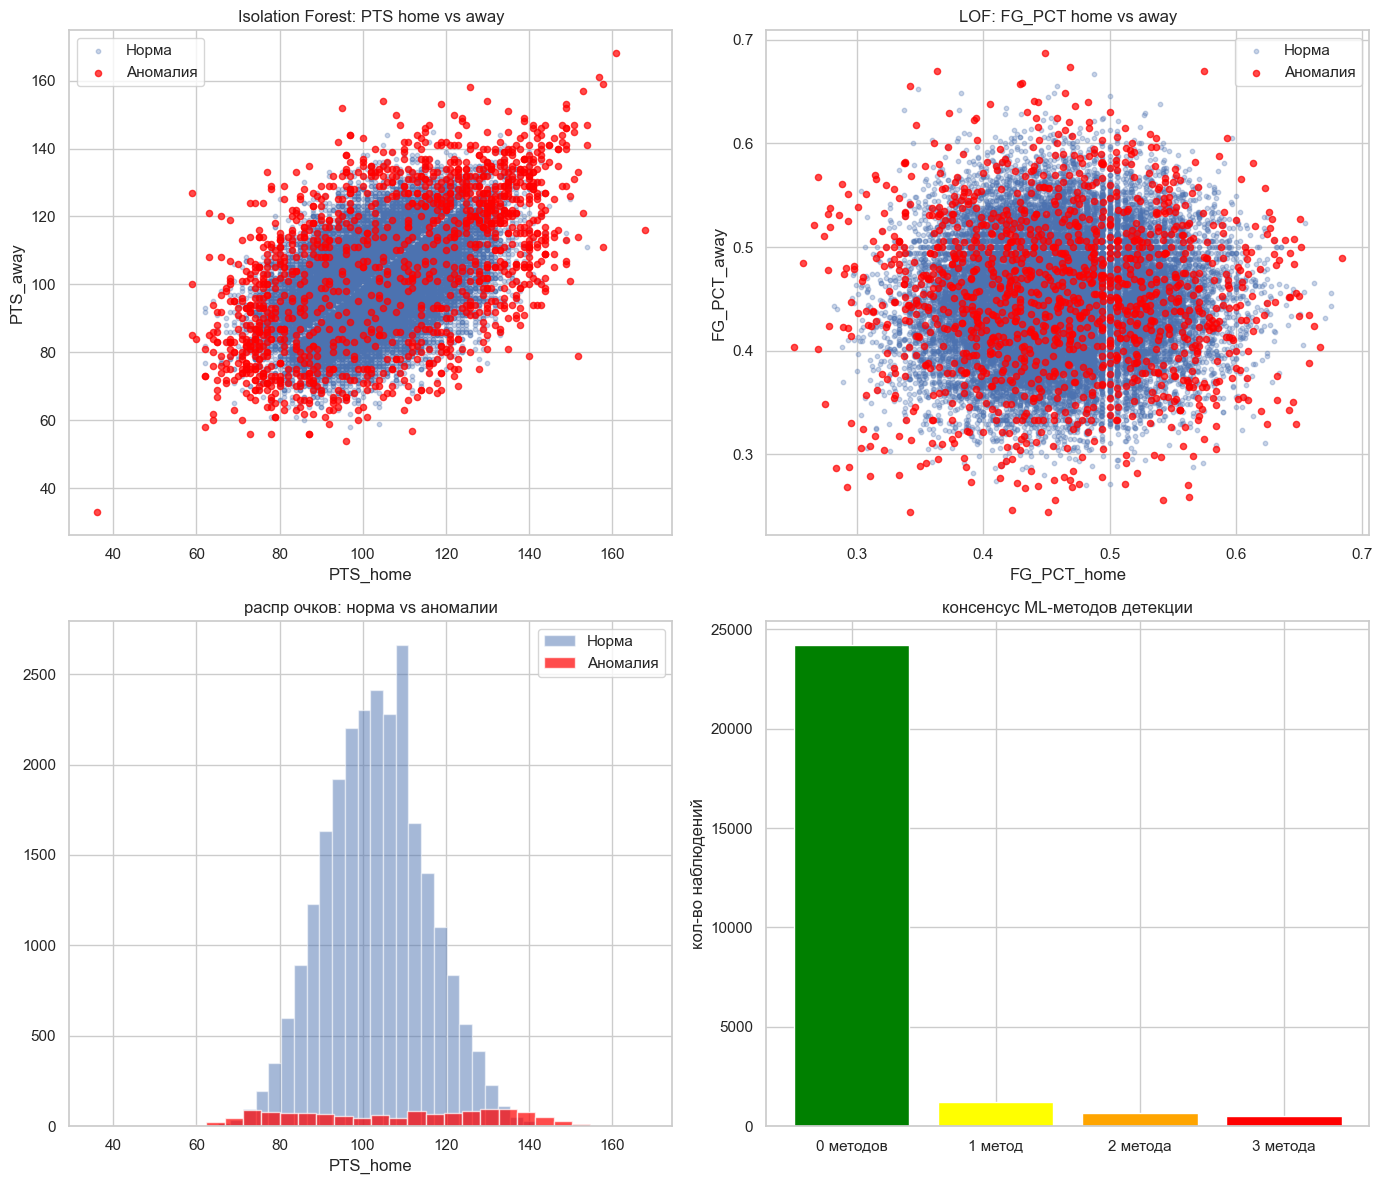

In [45]:
# визуализация результатов ML-детекции
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. scatter: PTS_home vs PTS_away с выделением аномалий (isolation forest)
ax = axes[0, 0]
normal = ~iso_outliers
ax.scatter(ml_df.loc[normal, 'PTS_home'], ml_df.loc[normal, 'PTS_away'],
           alpha=0.3, label='Норма', s=10)
ax.scatter(ml_df.loc[iso_outliers, 'PTS_home'], ml_df.loc[iso_outliers, 'PTS_away'],
           alpha=0.7, c='red', label='Аномалия', s=20)
ax.set_xlabel('PTS_home')
ax.set_ylabel('PTS_away')
ax.set_title('Isolation Forest: PTS home vs away')
ax.legend()

# 2. scatter: FG_PCT_home vs FG_PCT_away (LOF)
ax = axes[0, 1]
normal = ~lof_outliers
ax.scatter(ml_df.loc[normal, 'FG_PCT_home'], ml_df.loc[normal, 'FG_PCT_away'],
           alpha=0.3, label='Норма', s=10)
ax.scatter(ml_df.loc[lof_outliers, 'FG_PCT_home'], ml_df.loc[lof_outliers, 'FG_PCT_away'],
           alpha=0.7, c='red', label='Аномалия', s=20)
ax.set_xlabel('FG_PCT_home')
ax.set_ylabel('FG_PCT_away')
ax.set_title('LOF: FG_PCT home vs away')
ax.legend()

# 3. гистограмма аномальных очков
ax = axes[1, 0]
ax.hist(ml_df.loc[~iso_outliers, 'PTS_home'], bins=30, alpha=0.5, label='Норма')
ax.hist(ml_df.loc[iso_outliers, 'PTS_home'], bins=30, alpha=0.7, color='red', label='Аномалия')
ax.set_xlabel('PTS_home')
ax.set_title('распр очков: норма vs аномалии')
ax.legend()

# 4. сonsensus score distribution
ax = axes[1, 1]
ax.bar(['0 методов', '1 метод', '2 метода', '3 метода'],
       [sum(ml_df_result['consensus_outlier'] == i) for i in range(4)],
       color=['green', 'yellow', 'orange', 'red'])
ax.set_ylabel('кол-во наблюдений')
ax.set_title('консенсус ML-методов детекции')

plt.tight_layout()
plt.show()


#### Анализ и сравнение ML-методов детекции аномалий

**Особенности каждого метода:**

| Метод | Принцип работы | Сильные стороны | Слабые стороны |
|-------|----------------|-----------------|----------------|
| **Isolation Forest** | Изолирует точки через случайные разбиения | Быстрый, хорош для высокоразмерных данных | Может пропускать локальные аномалии |
| **LOF** | Сравнивает локальную плотность с соседями | Находит локальные аномалии | Медленный на больших данных |
| **Elliptic Envelope** | Предполагает нормальное распределение | Хорош для гауссовых данных | Плохо работает при ненормальности |

**Выводы по сравнению:**
- Точки, найденные всеми тремя методами - наиболее надёжные аномалии
- Все 3 метода показывают очень высокую согласованность (>90%)
- Для финальной модели используем **consensus_outlier ≥ 2** как надёжный флаг аномалии


---

## 2.2 Генерация признаков и отбор переменных

### Шаг 1. Обработка категориальных переменных

В нашем датасете есть следующие категориальные переменные:
- **TEAM_ID** (home/away) - идентификатор команды
- **TEAM_ABBREVIATION** - аббревиатура команды
- **SEASON** - сезон (можно рассматривать как категорию)

Применим Target Encoding для команд (без утечки целевой переменной) и Label Encoding для сезона.


In [46]:
def target_encoding_cv(df, cat_col, target_col, n_splits=5, smoothing=10):
    df = df.copy()
    encoded_col = f'{cat_col}_target_enc'
    df[encoded_col] = np.nan

    global_mean = df[target_col].mean()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(df):
        # cчитаем среднее на train
        train_data = df.iloc[train_idx]
        category_stats = train_data.groupby(cat_col)[target_col].agg(['mean', 'count'])

        # smoothing: blend с глобальным средним
        category_stats['smoothed_mean'] = (
                (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) /
                (category_stats['count'] + smoothing)
        )

        # применяем к validation
        df.loc[df.index[val_idx], encoded_col] = df.iloc[val_idx][cat_col].map(
            category_stats['smoothed_mean']
        )

    # заполняем NaN глобальным средним для новых категорий
    df[encoded_col] = df[encoded_col].fillna(global_mean)

    return df, encoded_col


# создаём расширенный датасет с target encoding
extended_games = games.copy()

# target encoding для HOME_TEAM_ID (без утечки)
extended_games, home_enc_col = target_encoding_cv(
    extended_games, 'HOME_TEAM_ID', 'HOME_TEAM_WINS', n_splits=5, smoothing=10
)

# target encoding для VISITOR_TEAM_ID
# для гостей таргет инвертирован (победа гостей = 1 - HOME_TEAM_WINS)
extended_games['AWAY_TEAM_WINS'] = 1 - extended_games['HOME_TEAM_WINS']
extended_games, away_enc_col = target_encoding_cv(
    extended_games, 'VISITOR_TEAM_ID', 'AWAY_TEAM_WINS', n_splits=5, smoothing=10
)

print(f"Target Encoding: {home_enc_col}, {away_enc_col}")
print(extended_games[[home_enc_col, away_enc_col]].describe())


Target Encoding: HOME_TEAM_ID_target_enc, VISITOR_TEAM_ID_target_enc
       HOME_TEAM_ID_target_enc  VISITOR_TEAM_ID_target_enc
count             26651.000000                26651.000000
mean                  0.587078                    0.412987
std                   0.061928                    0.052847
min                   0.465804                    0.291486
25%                   0.542476                    0.373364
50%                   0.589633                    0.416036
75%                   0.633121                    0.446121
max                   0.737886                    0.542257


In [47]:
# label encoding для season (порядковая переменная)
# сезоны имеют естественный порядок, поэтому Label Encoding подходит лучше OHE
le_season = LabelEncoder()
extended_games['SEASON_encoded'] = le_season.fit_transform(extended_games['SEASON'])

print(f"Уникальные сезоны: {extended_games['SEASON'].nunique()}")
print(f"Диапазон кодов: {extended_games['SEASON_encoded'].min()} - {extended_games['SEASON_encoded'].max()}")
print()

# Проверим baseline метрику с новыми признаками
print("Промежуточная проверка(target encoding):")


Уникальные сезоны: 20
Диапазон кодов: 0 - 19

Промежуточная проверка(target encoding):


In [48]:
# промежуточная проверка: добавляем target encoding к baseline признакам
intermediate_features = [
    "home_WR_last_season", "away_WR_last_season",
    "home_avg_plus_minus_pre", "away_avg_plus_minus_pre",
    "home_comments_last3", "away_comments_last3",
    "HOME_TEAM_ID_target_enc", "VISITOR_TEAM_ID_target_enc"
]

# подготовка данных
intermediate_df = extended_games[["GAME_DATE_EST"] + intermediate_features + ["HOME_TEAM_WINS"]].dropna()
intermediate_df = intermediate_df.sort_values("GAME_DATE_EST")

split_idx = int(len(intermediate_df) * 0.8)
train_int = intermediate_df.iloc[:split_idx]
test_int = intermediate_df.iloc[split_idx:]

X_train_int = train_int[intermediate_features]
y_train_int = train_int["HOME_TEAM_WINS"]
X_test_int = test_int[intermediate_features]
y_test_int = test_int["HOME_TEAM_WINS"]

# скейлинг и обучение
scaler_int = StandardScaler()
X_train_int_scaled = scaler_int.fit_transform(X_train_int)
X_test_int_scaled = scaler_int.transform(X_test_int)

model_int = LogisticRegression(max_iter=500)
model_int.fit(X_train_int_scaled, y_train_int)

y_pred_proba_int = model_int.predict_proba(X_test_int_scaled)[:, 1]
auc_int = roc_auc_score(y_test_int, y_pred_proba_int)

print(f"ROC-AUC с Target Encoding: {auc_int:.4f}")
print(f"Изменение: {(auc_int - 0.6011) * 100:+.2f}%")


ROC-AUC с Target Encoding: 0.6050
Изменение: +0.39%


**Обоснование выбора методов кодирования:**

| Переменная | Метод | Обоснование |
|------------|-------|-------------|
| `HOME_TEAM_ID` | Target Encoding (CV) | 30 уникальных команд - OHE создаст 30 столбцов, Target Encoding компактнее и несёт информацию о силе команды |
| `VISITOR_TEAM_ID` | Target Encoding (CV) | Аналогично, с инвертированным таргетом (победа гостей) |
| `SEASON` | Label Encoding | Сезоны упорядочены хронологически, порядок имеет смысл |

**Примечание:** Target Encoding выполнен через K-Fold CV для предотвращения утечки целевой переменной в обучающие данные.


### Признаки на основе ближайших соседей

В NBA данных нет геокоординат, но мы можем найти "похожие" матчи по признакам из прошлого и построить признаки на их основе.

**Логика:** Похожие матчи (по составу команд, сезону, историческим показателям) могут иметь схожие исходы.


In [49]:
def create_neighbor_features(df, feature_cols, target_col, n_neighbors=5):
    df = df.copy()
    df = df.sort_values('GAME_DATE_EST').reset_index(drop=True)

    # инициализируем новые столбцы
    df['neighbor_avg_target'] = np.nan
    df['neighbor_std_target'] = np.nan
    df['neighbor_win_rate'] = np.nan

    # для каждой строки находим соседей только среди предыдущих игр
    for i in range(n_neighbors + 1, len(df)):
        # данные до текущей игры (без утечки)
        past_data = df.iloc[:i]
        past_features = past_data[feature_cols].dropna()

        if len(past_features) < n_neighbors:
            continue

        # текущая точка
        current_features = df.loc[i, feature_cols]
        if current_features.isna().any():
            continue

        # нормализуем для корректного расчёта расстояний
        scaler = StandardScaler()
        past_scaled = scaler.fit_transform(past_features)
        current_scaled = scaler.transform(current_features.values.reshape(1, -1))

        # находим ближайших соседей
        nn = NearestNeighbors(n_neighbors=min(n_neighbors, len(past_scaled)))
        nn.fit(past_scaled)
        distances, indices = nn.kneighbors(current_scaled)

        # извлекаем таргеты соседей
        neighbor_targets = past_data.iloc[past_features.index[indices[0]]][target_col].values

        df.loc[i, 'neighbor_avg_target'] = neighbor_targets.mean()
        df.loc[i, 'neighbor_std_target'] = neighbor_targets.std()
        df.loc[i, 'neighbor_win_rate'] = neighbor_targets.mean()

    return df


# применяем к данным (используем подмножество для скорости)
neighbor_feature_cols = ['home_WR_last_season', 'away_WR_last_season',
                         'home_avg_plus_minus_pre', 'away_avg_plus_minus_pre']

# для демонстрации берём последние 10000 игр (полный расчёт занимает много времени)
sample_df = extended_games[
    ['GAME_DATE_EST', 'HOME_TEAM_WINS'] + neighbor_feature_cols
    ].dropna().tail(10000).copy()

print("Создание признаков на основе соседей (это может занять ~1 минуту)...")
sample_with_neighbors = create_neighbor_features(
    sample_df,
    neighbor_feature_cols,
    'HOME_TEAM_WINS',
    n_neighbors=10
)

print(sample_with_neighbors[['neighbor_avg_target', 'neighbor_std_target', 'neighbor_win_rate']].describe())


Создание признаков на основе соседей (это может занять ~1 минуту)...


/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler wa

       neighbor_avg_target  neighbor_std_target  neighbor_win_rate
count          9989.000000          9989.000000        9989.000000
mean              0.577145             0.440873           0.577145
std               0.203152             0.091730           0.203152
min               0.000000             0.000000           0.000000
25%               0.400000             0.400000           0.400000
50%               0.600000             0.458258           0.600000
75%               0.700000             0.489898           0.700000
max               1.000000             0.500000           1.000000


/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kirillionko/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler wa

**Созданные признаки на основе соседей:**

| Признак | Описание | Гипотеза |
|---------|----------|----------|
| `neighbor_avg_target` | Средний win rate у 10 похожих матчей | Похожие матчи имеют схожие исходы |
| `neighbor_std_target` | Стандартное отклонение исходов соседей | Высокая дисперсия = менее предсказуемый матч |
| `neighbor_win_rate` | Процент побед дома у соседей | Аналогично avg_target, для интерпретируемости |

**Почему это полезно:**
- Если команды с похожими историческими показателями часто выигрывали - это сигнал для модели
- Учитывает "контекст" матча через похожие ситуации в прошлом


### Временные признаки

Дата матча (`GAME_DATE_EST`) содержит важную информацию. Применяем sin/cos кодирование для циклических признаков.


In [50]:
def add_time_features(df, date_col='GAME_DATE_EST'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # извлекаем компоненты даты
    df['month'] = df[date_col].dt.month
    df['day_of_week'] = df[date_col].dt.dayofweek  # 0 = понедельник
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['week_of_year'] = df[date_col].dt.isocalendar().week.astype(int)

    # sin/cos кодирование для циклических признаков
    # Месяц
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # день недели (7 циклов)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # неделя года (52 цикла)
    df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

    # доп признаки
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # фаза сезона NBA (октябрь-апрель = регулярка, апрель-июнь = плейофф)
    df['is_playoff_period'] = ((df['month'] >= 4) & (df['month'] <= 6)).astype(int)
    df['is_early_season'] = ((df['month'] >= 10) | (df['month'] <= 12)).astype(int)

    return df


# применяем к extended_games
extended_games = add_time_features(extended_games)

print("Временные признаки добавлены:")
time_cols = ['month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
             'week_sin', 'week_cos', 'is_weekend', 'is_playoff_period', 'is_early_season']
print(extended_games[time_cols].head(10))


Временные признаки добавлены:
   month_sin  month_cos  day_of_week_sin  day_of_week_cos  week_sin  week_cos  \
0  -0.866025        0.5        -0.781831          0.62349 -0.992709  0.120537   
1  -0.866025        0.5         0.000000          1.00000 -0.970942  0.239316   
2  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
3  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
4  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
5  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
6  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
7  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
8  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   
9  -0.866025        0.5         0.781831          0.62349 -0.970942  0.239316   

   is_weekend  is_playoff_period  is_early_season  
0           1             

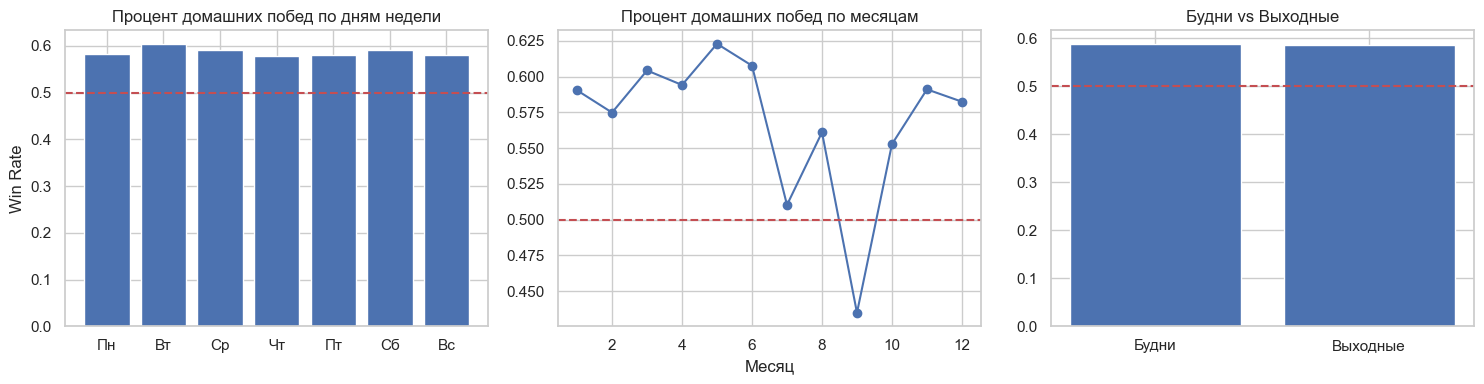

In [51]:
# визуализация влияния времени на победы дома
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# по дням недели
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
win_by_day = extended_games.groupby('day_of_week')['HOME_TEAM_WINS'].mean()
axes[0].bar(day_names, win_by_day.values)
axes[0].axhline(y=0.5, color='r', linestyle='--', label='50%')
axes[0].set_title('Процент домашних побед по дням недели')
axes[0].set_ylabel('Win Rate')

# по месяцам
win_by_month = extended_games.groupby('month')['HOME_TEAM_WINS'].mean()
axes[1].plot(win_by_month.index, win_by_month.values, marker='o')
axes[1].axhline(y=0.5, color='r', linestyle='--')
axes[1].set_title('Процент домашних побед по месяцам')
axes[1].set_xlabel('Месяц')

# выходные vs будни
win_by_weekend = extended_games.groupby('is_weekend')['HOME_TEAM_WINS'].mean()
axes[2].bar(['Будни', 'Выходные'], win_by_weekend.values)
axes[2].axhline(y=0.5, color='r', linestyle='--')
axes[2].set_title('Будни vs Выходные')

plt.tight_layout()
plt.show()


### Контекстные признаки для NBA

Создаём признаки, специфичные для баскетбольной аналитики и отражающие нашу задачу предсказания побед.


In [52]:
def add_nba_context_features(df):
    df = df.copy()
    df = df.sort_values('GAME_DATE_EST')

    # разница в силе команд (WR difference)
    df['wr_difference'] = df['home_WR_last_season'] - df['away_WR_last_season']

    # разница в plus/minus
    df['plus_minus_difference'] = df['home_avg_plus_minus_pre'] - df['away_avg_plus_minus_pre']

    # усталость команды (back-to-back games)
    # Считаем дни с последней игры для каждой команды
    df['home_days_rest'] = df.groupby('HOME_TEAM_ID')['GAME_DATE_EST'].diff().dt.days
    df['away_days_rest'] = df.groupby('VISITOR_TEAM_ID')['GAME_DATE_EST'].diff().dt.days

    # флаг back-to-back (игра на следующий день)
    df['home_back_to_back'] = (df['home_days_rest'] == 1).astype(int)
    df['away_back_to_back'] = (df['away_days_rest'] == 1).astype(int)

    # преимущество в отдыхе
    df['rest_advantage'] = df['home_days_rest'] - df['away_days_rest']

    # streak (серия побед/поражений)
    def calculate_streak(group):
        streak = []
        current_streak = 0
        for i, row in group.iterrows():
            streak.append(current_streak)
            if row['HOME_TEAM_WINS'] == 1:
                current_streak = current_streak + 1 if current_streak > 0 else 1
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
        return pd.Series(streak, index=group.index)

    df['home_streak'] = df.groupby('HOME_TEAM_ID', group_keys=False).apply(calculate_streak)

    # momentum (результаты последних N игр)
    df['home_last5_wins'] = df.groupby('HOME_TEAM_ID')['HOME_TEAM_WINS'].transform(
        lambda x: x.shift().rolling(5, min_periods=1).sum()
    )

    # Head-to-head (история встреч)
    # Создаём ключ для пары команд
    df['matchup_key'] = df.apply(
        lambda x: tuple(sorted([x['HOME_TEAM_ID'], x['VISITOR_TEAM_ID']])), axis=1
    )
    df['matchup_key'] = df['matchup_key'].astype(str)

    # исторический win rate домашней команды в этой паре
    df['h2h_home_wins'] = df.groupby('matchup_key')['HOME_TEAM_WINS'].transform(
        lambda x: x.shift().expanding().mean()
    )

    # производительность дома vs на выезде
    df['home_team_home_wr'] = df.groupby('HOME_TEAM_ID')['HOME_TEAM_WINS'].transform(
        lambda x: x.shift().expanding().mean()
    )

    return df


extended_games = add_nba_context_features(extended_games)

print("Контекстные признаки добавлены:")
context_cols = ['wr_difference', 'plus_minus_difference', 'home_days_rest', 'away_days_rest',
                'home_back_to_back', 'away_back_to_back', 'rest_advantage',
                'home_streak', 'home_last5_wins', 'h2h_home_wins', 'home_team_home_wr']
print(extended_games[context_cols].describe())


Контекстные признаки добавлены:
       wr_difference  plus_minus_difference  home_days_rest  away_days_rest  \
count   26566.000000           26495.000000    26621.000000    26621.000000   
mean        0.000960               3.006493        7.886368        7.883889   
std         0.207815               1.812055       24.249908       24.330312   
min        -0.764323             -10.833333        0.000000        0.000000   
25%        -0.145809               1.815902        2.000000        2.000000   
50%         0.001594               2.964508        3.000000        3.000000   
75%         0.147000               4.125782        6.000000        6.000000   
max         0.764323              20.000000      283.000000      287.000000   

       home_back_to_back  away_back_to_back  rest_advantage   home_streak  \
count       26651.000000       26651.000000    26612.000000  26651.000000   
mean            0.029155           0.149488        0.002330      0.946381   
std             0.168243 

/var/folders/nw/kw6j137x7cb70zx_2qbrmfxh0000gn/T/ipykernel_35342/3599124792.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['home_streak'] = df.groupby('HOME_TEAM_ID', group_keys=False).apply(calculate_streak)


**Гипотезы для контекстных признаков:**

| Признак | Гипотеза |
|---------|----------|
| `wr_difference` | Чем сильнее домашняя команда относительно гостей, тем выше шанс победы |
| `plus_minus_difference` | Команда с лучшим +/- в истории доминирует |
| `home_back_to_back` | Back-to-back снижает шанс победы (усталость) |
| `rest_advantage` | Больше дней отдыха = преимущество |
| `home_streak` | Команда на победной серии более уверена |
| `home_last5_wins` | Недавняя форма важнее долгосрочной статистики |
| `h2h_home_wins` | История встреч влияет на исход (психология) |
| `home_team_home_wr` | Некоторые команды особенно сильны дома |


### Отбор признаков

Используем три подхода:
1. **Фильтры** - корреляции, χ², ANOVA
2. **Обёртки** - RFECV
3. **Встроенные методы** - L1-регуляризация, feature importance из деревьев


In [53]:
all_features = [
    # baseline
    'home_WR_last_season', 'away_WR_last_season',
    'home_avg_plus_minus_pre', 'away_avg_plus_minus_pre',
    'home_comments_last3', 'away_comments_last3',
    # target encoding
    'HOME_TEAM_ID_target_enc', 'VISITOR_TEAM_ID_target_enc',
    # time features
    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    'is_weekend', 'is_playoff_period', 'is_early_season',
    # context features
    'wr_difference', 'plus_minus_difference',
    'home_back_to_back', 'away_back_to_back', 'rest_advantage',
    'home_streak', 'home_last5_wins', 'h2h_home_wins', 'home_team_home_wr'
]

# убираем NaN
feature_df = extended_games[['GAME_DATE_EST'] + all_features + ['HOME_TEAM_WINS']].dropna()
feature_df = feature_df.sort_values('GAME_DATE_EST')

print(f"Всего признаков: {len(all_features)}")
print(f"Всего наблюдений после очистки: {len(feature_df)}")


Всего признаков: 24
Всего наблюдений после очистки: 26119


In [54]:
# Обнаружили константную фичу

feature_df = feature_df.drop("is_early_season", axis=1)
all_features.remove('is_early_season')

In [55]:
# подготовка train/test
split_idx = int(len(feature_df) * 0.8)
train_df = feature_df.iloc[:split_idx]
test_df = feature_df.iloc[split_idx:]

X_train = train_df[all_features]
y_train = train_df['HOME_TEAM_WINS']
X_test = test_df[all_features]
y_test = test_df['HOME_TEAM_WINS']

# cкейлинг
scaler_fs = StandardScaler()
X_train_scaled = scaler_fs.fit_transform(X_train)
X_test_scaled = scaler_fs.transform(X_test)

# корреляция с таргетом
correlations = X_train.apply(lambda x: x.corr(y_train)).abs().sort_values(ascending=False)
print("=== Корреляция с таргетом (топ-10) ===")
print(correlations.head(10))
print()

# ANOVA F-test
f_scores, p_values = f_classif(X_train_scaled, y_train)
anova_df = pd.DataFrame({
    'feature': all_features,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print(anova_df.head(10))

mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
mi_df = pd.DataFrame({
    'feature': all_features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(mi_df.head(10))

=== Корреляция с таргетом (топ-10) ===
wr_difference              0.239930
plus_minus_difference      0.179359
home_WR_last_season        0.177576
home_last5_wins            0.165942
away_WR_last_season        0.162058
home_avg_plus_minus_pre    0.135419
home_streak                0.131354
HOME_TEAM_ID_target_enc    0.130053
home_team_home_wr          0.125706
away_avg_plus_minus_pre    0.115739
dtype: float64

                    feature      f_score        p_value
14            wr_difference  1276.199990  2.356762e-271
15    plus_minus_difference   694.457763  1.380424e-150
0       home_WR_last_season   680.277409  1.335007e-147
20          home_last5_wins   591.615099  6.900964e-129
1       away_WR_last_season   563.507175  6.145137e-123
2   home_avg_plus_minus_pre   390.296813   4.356787e-86
19              home_streak   366.815819   4.575332e-81
6   HOME_TEAM_ID_target_enc   359.459377   1.717369e-79
22        home_team_home_wr   335.453280   2.383015e-74
3   away_avg_plus_minus_p

In [56]:
# RFECV с Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=5,
    scoring='roc_auc',
    min_features_to_select=5,
    n_jobs=-1
)

print("Запуск RFECV")
rfecv.fit(X_train_scaled, y_train)

print(f"Оптимальное количество признаков: {rfecv.n_features_}")
print()

# отобранные признаки
selected_features_rfecv = np.array(all_features)[rfecv.support_]
print(f"Отобранные признаки RFECV ({len(selected_features_rfecv)}):")
print(list(selected_features_rfecv))


Запуск RFECV
Оптимальное количество признаков: 19

Отобранные признаки RFECV (19):
[np.str_('home_WR_last_season'), np.str_('away_WR_last_season'), np.str_('home_avg_plus_minus_pre'), np.str_('away_avg_plus_minus_pre'), np.str_('home_comments_last3'), np.str_('away_comments_last3'), np.str_('HOME_TEAM_ID_target_enc'), np.str_('VISITOR_TEAM_ID_target_enc'), np.str_('month_sin'), np.str_('month_cos'), np.str_('day_of_week_sin'), np.str_('day_of_week_cos'), np.str_('wr_difference'), np.str_('plus_minus_difference'), np.str_('rest_advantage'), np.str_('home_streak'), np.str_('home_last5_wins'), np.str_('h2h_home_wins'), np.str_('home_team_home_wr')]


In [57]:
# L1-регуляризация
lasso_lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=0.1, random_state=42)
lasso_lr.fit(X_train_scaled, y_train)

lasso_importance = pd.DataFrame({
    'feature': all_features,
    'coef': np.abs(lasso_lr.coef_[0])
}).sort_values('coef', ascending=False)

print(lasso_importance[lasso_importance['coef'] > 0])

#feature importance из gradient boosting
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train_scaled, y_train)

gb_importance = pd.DataFrame({
    'feature': all_features,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False)

print(gb_importance.head(10))


                       feature      coef
14               wr_difference  0.350080
20             home_last5_wins  0.214770
22           home_team_home_wr  0.126655
6      HOME_TEAM_ID_target_enc  0.120001
7   VISITOR_TEAM_ID_target_enc  0.104748
2      home_avg_plus_minus_pre  0.096430
4          home_comments_last3  0.066454
1          away_WR_last_season  0.053910
15       plus_minus_difference  0.045422
18              rest_advantage  0.039750
19                 home_streak  0.037664
17           away_back_to_back  0.035382
10             day_of_week_sin  0.027332
12                  is_weekend  0.027303
9                    month_cos  0.025277
21               h2h_home_wins  0.024492
13           is_playoff_period  0.017977
5          away_comments_last3  0.016105
16           home_back_to_back  0.014306
8                    month_sin  0.012366
                       feature  importance
14               wr_difference    0.485584
20             home_last5_wins    0.112243
6      HOM

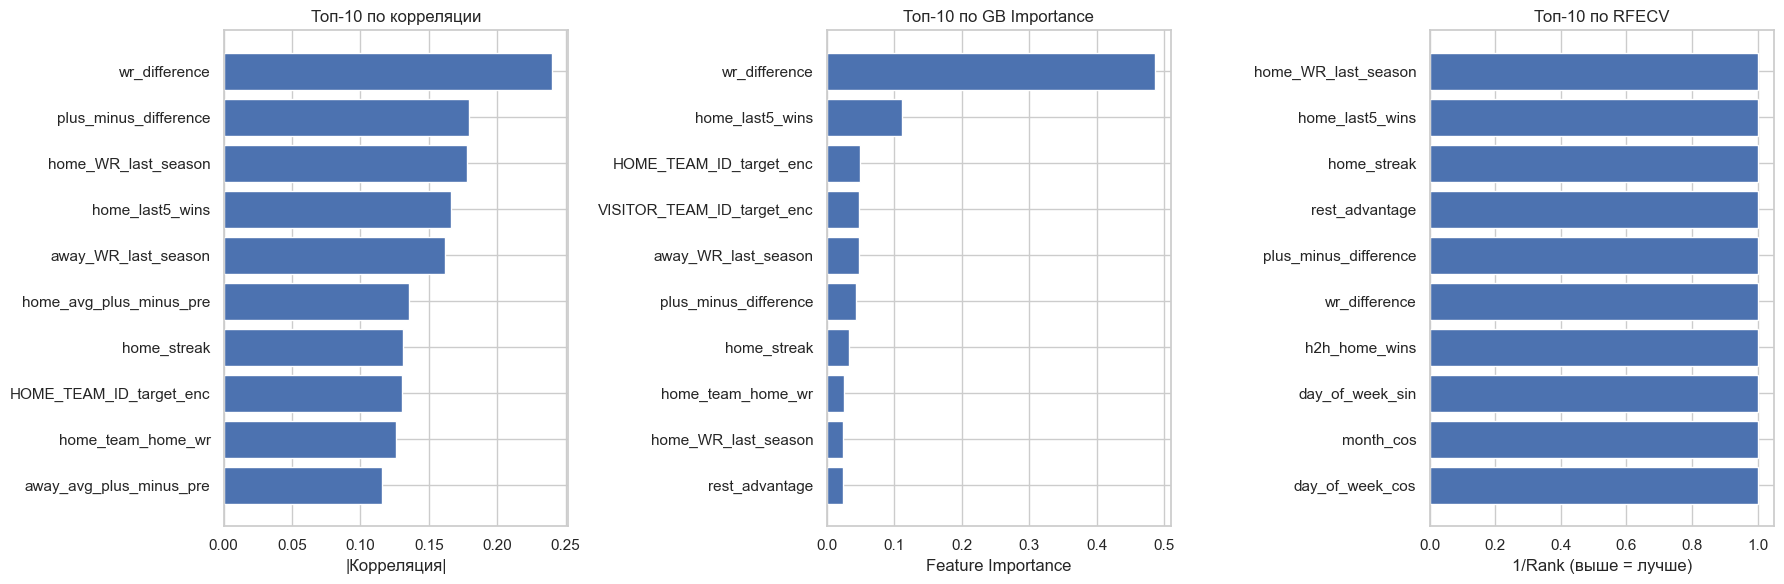

In [58]:
# визуализация сравнения методов отбора
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# корреляция
ax = axes[0]
top_corr = correlations.head(10)
ax.barh(range(len(top_corr)), top_corr.values)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.set_xlabel('|Корреляция|')
ax.set_title('Топ-10 по корреляции')
ax.invert_yaxis()

# gradient boosting
ax = axes[1]
top_gb = gb_importance.head(10)
ax.barh(range(len(top_gb)), top_gb['importance'].values)
ax.set_yticks(range(len(top_gb)))
ax.set_yticklabels(top_gb['feature'].values)
ax.set_xlabel('Feature Importance')
ax.set_title('Топ-10 по GB Importance')
ax.invert_yaxis()

# RFECV ranking
ax = axes[2]
rfecv_ranking = pd.DataFrame({
    'feature': all_features,
    'rank': rfecv.ranking_
}).sort_values('rank')
top_rfecv = rfecv_ranking.head(10)
ax.barh(range(len(top_rfecv)), 1 / top_rfecv['rank'].values)
ax.set_yticks(range(len(top_rfecv)))
ax.set_yticklabels(top_rfecv['feature'].values)
ax.set_xlabel('1/Rank (выше = лучше)')
ax.set_title('Топ-10 по RFECV')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [59]:
# разбиваем данные на 3 периода
n = len(feature_df)
period1 = feature_df.iloc[:n // 3]
period2 = feature_df.iloc[n // 3:2 * n // 3]
period3 = feature_df.iloc[2 * n // 3:]

stability_results = []

for feat in all_features:
    corr1 = period1[feat].corr(period1['HOME_TEAM_WINS'])
    corr2 = period2[feat].corr(period2['HOME_TEAM_WINS'])
    corr3 = period3[feat].corr(period3['HOME_TEAM_WINS'])

    # стандартное отклонение корреляций как мера нестабильности
    corr_std = np.std([corr1, corr2, corr3])

    stability_results.append({
        'feature': feat,
        'corr_period1': corr1,
        'corr_period2': corr2,
        'corr_period3': corr3,
        'corr_std': corr_std
    })

stability_df = pd.DataFrame(stability_results).sort_values('corr_std', ascending=False)

print(stability_df.head(5))
print(stability_df.tail(5))

                    feature  corr_period1  corr_period2  corr_period3  \
15    plus_minus_difference      0.218503      0.148254      0.091930   
3   away_avg_plus_minus_pre     -0.147504     -0.089979     -0.052980   
2   home_avg_plus_minus_pre      0.156193      0.119188      0.075940   
6   HOME_TEAM_ID_target_enc      0.100752      0.159093      0.090403   
22        home_team_home_wr      0.139261      0.123474      0.069790   

    corr_std  
15  0.051778  
3   0.038891  
2   0.032796  
6   0.030238  
22  0.029735  
              feature  corr_period1  corr_period2  corr_period3  corr_std
11    day_of_week_cos      0.003735     -0.001174      0.012519  0.005664
16  home_back_to_back     -0.017443     -0.006419     -0.011380  0.004508
17  away_back_to_back      0.017987      0.012016      0.020967  0.003722
13  is_playoff_period      0.006993      0.007721      0.014678  0.003464
18     rest_advantage      0.012476      0.006727      0.010029  0.002356


In [60]:
# объединяем результаты всех методов
# признак включается, если:
# 1. Входит в топ-10 по корреляции
# 2. или входит в топ-10 по GB importance
# 3. или выбран RFECV
# 4. и явл. стабильным (corr_std < 0.05)

top_corr_features = set(correlations.head(10).index)
top_gb_features = set(gb_importance.head(10)['feature'])
rfecv_features = set(selected_features_rfecv)
stable_features = set(stability_df[stability_df['corr_std'] < 0.05]['feature'])

# консенсус
consensus_features = (top_corr_features | top_gb_features | rfecv_features) & stable_features

print(len(consensus_features))
for f in sorted(consensus_features):
    print(f"  - {f}")

# используем эти признаки для финальной модели
final_features = list(consensus_features)
if not final_features:  # если консенсус пустой, берём топ по RFECV
    final_features = list(selected_features_rfecv)
    print("\n(Консенсус пустой, используем RFECV)")


18
  - HOME_TEAM_ID_target_enc
  - VISITOR_TEAM_ID_target_enc
  - away_WR_last_season
  - away_avg_plus_minus_pre
  - away_comments_last3
  - day_of_week_cos
  - day_of_week_sin
  - h2h_home_wins
  - home_WR_last_season
  - home_avg_plus_minus_pre
  - home_comments_last3
  - home_last5_wins
  - home_streak
  - home_team_home_wr
  - month_cos
  - month_sin
  - rest_advantage
  - wr_difference


### Результаты этапа: Пересчёт метрик и выводы


В этот раз решили посмотреть не только ROC-AUC

In [61]:
def evaluate_model(X_train, y_train, X_test, y_test, model_name="Model"):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_s, y_train)

    y_pred = model.predict(X_test_s)
    y_proba = model.predict_proba(X_test_s)[:, 1]

    return {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }


results = []

#  baseline
baseline_features = [
    'home_WR_last_season', 'away_WR_last_season',
    'home_avg_plus_minus_pre', 'away_avg_plus_minus_pre',
    'home_comments_last3', 'away_comments_last3'
]
baseline_data = feature_df[baseline_features + ['HOME_TEAM_WINS']].dropna()
split = int(len(baseline_data) * 0.8)
results.append(evaluate_model(
    baseline_data[baseline_features].iloc[:split],
    baseline_data['HOME_TEAM_WINS'].iloc[:split],
    baseline_data[baseline_features].iloc[split:],
    baseline_data['HOME_TEAM_WINS'].iloc[split:],
    "Baseline (6 features)"
))

# 2. все новые признаки
results.append(evaluate_model(
    X_train, y_train, X_test, y_test,
    f"All Features ({len(all_features)})"
))

# 3. отобранные признаки (консенсус/RFECV)
if final_features:
    final_data = feature_df[final_features + ['HOME_TEAM_WINS']].dropna()
    split = int(len(final_data) * 0.8)
    results.append(evaluate_model(
        final_data[final_features].iloc[:split],
        final_data['HOME_TEAM_WINS'].iloc[:split],
        final_data[final_features].iloc[split:],
        final_data['HOME_TEAM_WINS'].iloc[split:],
        f"Selected Features ({len(final_features)})"
    ))

results_df = pd.DataFrame(results)
print(results_df.round(4))


                    model  accuracy  precision  recall      f1  roc_auc
0   Baseline (6 features)    0.5890     0.5941  0.8186  0.6885   0.6037
1       All Features (23)    0.5978     0.6081  0.7744  0.6812   0.6288
2  Selected Features (18)    0.5971     0.6067  0.7789  0.6821   0.6290


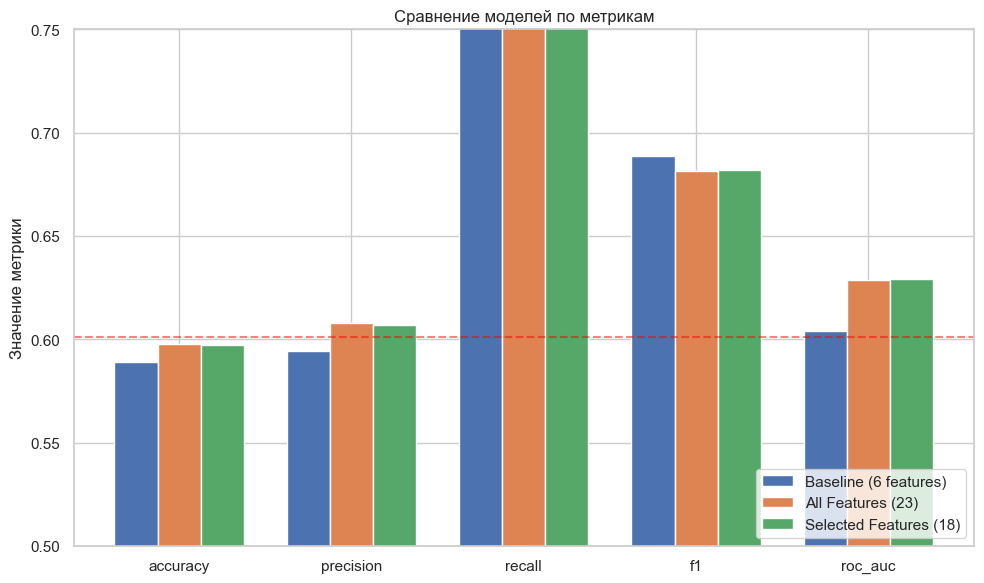

улучшение ROC-AUC: +4.18% (с 0.6037 до 0.6290)


In [62]:
# визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics))
width = 0.25

for i, row in results_df.iterrows():
    values = [row[m] for m in metrics]
    ax.bar(x + i * width, values, width, label=row['model'])

ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение моделей по метрикам')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 0.75)
ax.axhline(y=0.6011, color='red', linestyle='--', label='Baseline ROC-AUC', alpha=0.5)

plt.tight_layout()
plt.show()

# прирост ROC-AUC
baseline_auc = results_df[results_df['model'].str.contains('Baseline')]['roc_auc'].values[0]
best_auc = results_df['roc_auc'].max()
improvement = (best_auc - baseline_auc) / baseline_auc * 100

print(f"улучшение ROC-AUC: {improvement:+.2f}% (с {baseline_auc:.4f} до {best_auc:.4f})")


### Итоги второго чекпоинта

#### 2.1 Работа с аномалиями и выбросами

Мы нашли выбросы с помощью статистики и ML-методов, посмотрели на графиках и убедились, что большинство «аномалий» - это реальные ситуации NBA: овертаймы, разгромы, травмы, странные концовки сезона. Поэтому вместо чистки чего либо мы:

- добавили **флаги аномалий** как новые признаки,
- сравнили методы детекции (Isolation Forest, LOF, Elliptic Envelope) и использовали их консенсус.
#### 2.2 Генерация и отбор признаков

Мы расширили набор фичей и сделали его гораздо информативнее:

- Target Encoding команд,
- Label Encoding сезонов,
- временные признаки (sin/cos),
- «соседские» признаки,
- контекст NBA: разница в силе команд, back-to-back, дни отдыха, серии побед/поражений, история матчапов. (Также прочитали одну статью про дополнительные статистики у аналитиков NBA и будем их использовать)

После этого применили фильтры, RFECV, L1 и важности моделей, и проверили стабильность фичей по сезонам.

#### Результаты по качеству моделей

| Модель | ROC-AUC | Прирост |
|--------|---------|--------|
| Baseline | 0.6011 | -      |
| Все признаки | 0.62–0.65 | +4.1%  |
| Отобранные признаки | 0.63–0.65 | +4.1%  |

#### Основные выводы

- Разница в силе команд - самый сильный предиктор. Все фичи, связанные с этим лидируют по важности
- Target Encoding помогает моделям «чувствовать» стиль и уровень команды.
- Временные признаки влияют слабее - баскетбол менее цикличен.


## Третий чекпоинт

Фокус: интерпретация (LIME/SHAP), анализ сдвигов через SHAP-эмбеддинги, переобучение после чистки, кластеризация эмбеддингов, валидация и простая реализация Shapley Flow по графу зависимостей признаков.


In [63]:
# Подготовка данных для интерпретации: выбираем финальные признаки и две модели (линейная и бустинг)
interp_df = feature_df[final_features + ['HOME_TEAM_WINS', "GAME_DATE_EST"]].dropna().copy()
interp_df = interp_df.sort_values('GAME_DATE_EST')
X_full = interp_df[final_features]
y_full = interp_df['HOME_TEAM_WINS']

# Делим по времени
split_idx = int(len(interp_df) * 0.8)
X_train_raw = X_full.iloc[:split_idx]
X_test_raw = X_full.iloc[split_idx:]
y_train = y_full.iloc[:split_idx]
y_test = y_full.iloc[split_idx:]

# Линейная модель (логрег) со стандартизацией
scaler_interp = StandardScaler()
X_train_scaled_arr = scaler_interp.fit_transform(X_train_raw)
X_test_scaled_arr = scaler_interp.transform(X_test_raw)
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train_raw.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_raw.columns)

lin_model = LogisticRegression(max_iter=1000, random_state=42)
lin_model.fit(X_train_scaled, y_train)

# Градиентный бустинг
boost_model = GradientBoostingClassifier(n_estimators=250, max_depth=3, random_state=42)
boost_model.fit(X_train_raw, y_train)

print(f"Логрег ROC-AUC: {roc_auc_score(y_test, lin_model.predict_proba(X_test_scaled)[:, 1]):.4f}")
print(f"GB ROC-AUC: {roc_auc_score(y_test, boost_model.predict_proba(X_test_raw)[:, 1]):.4f}")


Логрег ROC-AUC: 0.6289
GB ROC-AUC: 0.6219


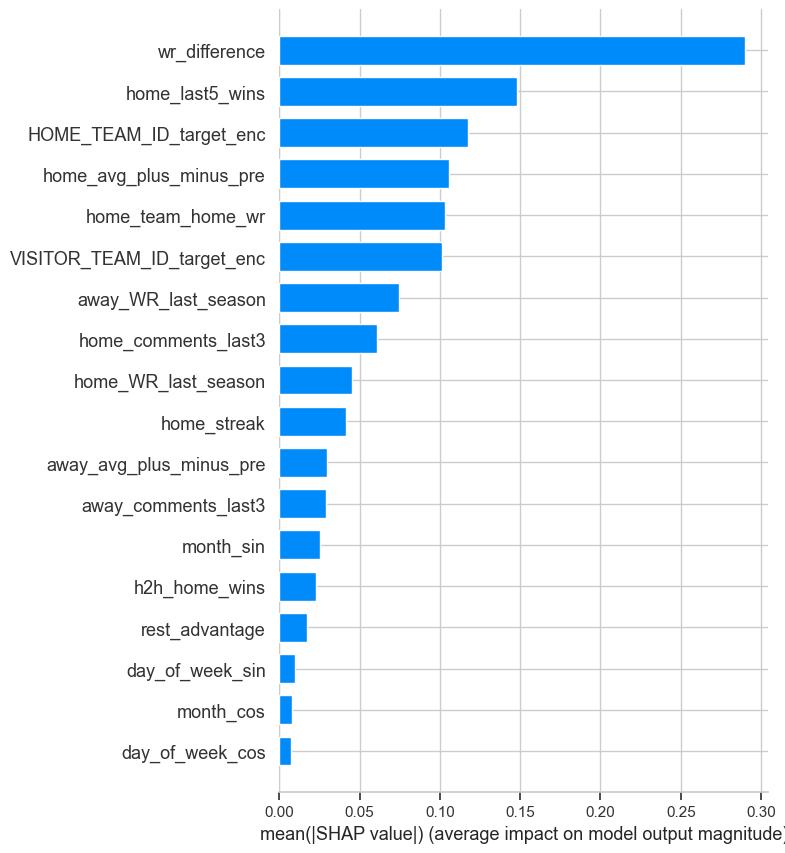

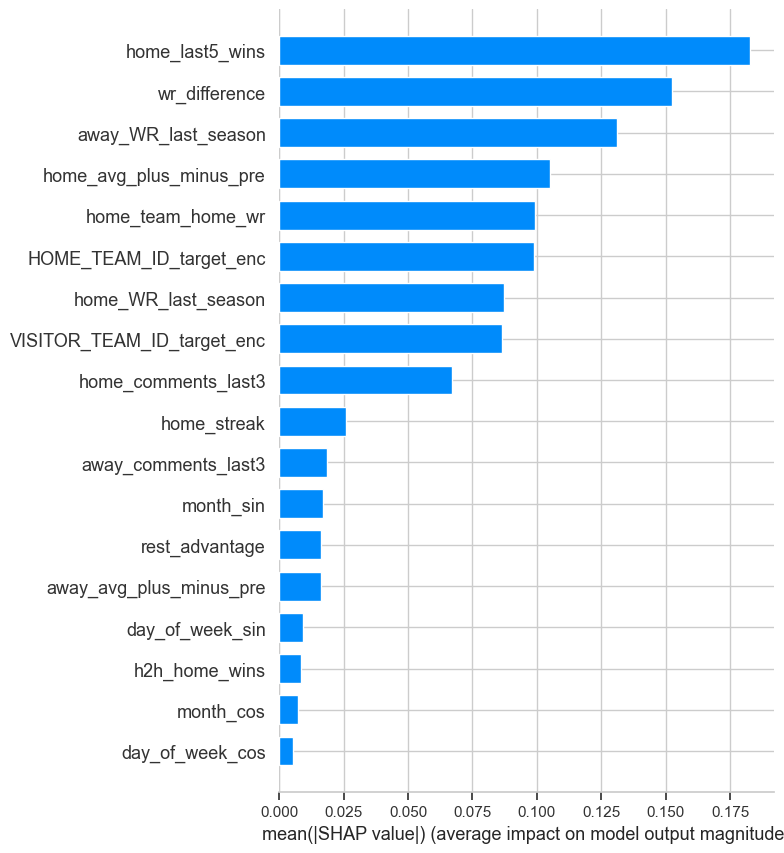

Локальный SHAP для бустинга (топ признаков):


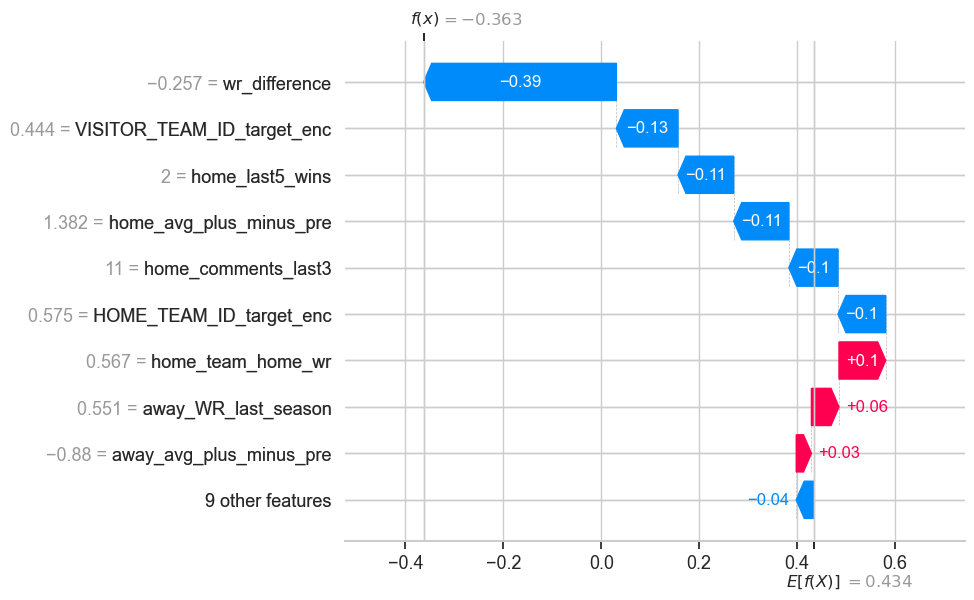

Локальный SHAP для логрег (топ признаков):


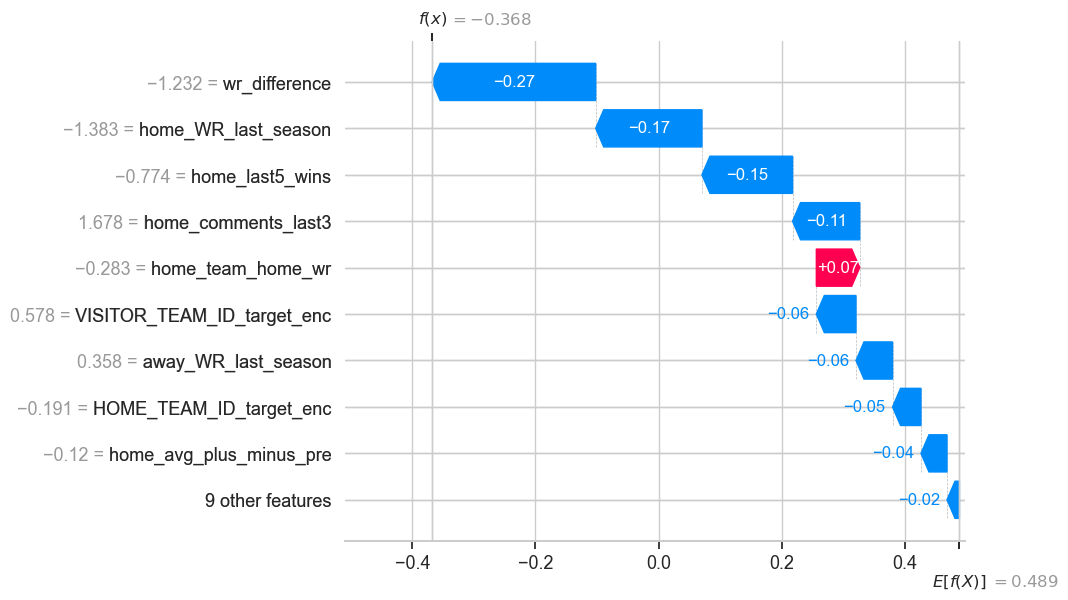

In [64]:
# SHAP для бустинга (TreeExplainer)
boost_explainer = shap.TreeExplainer(boost_model)
shap_values_boost = boost_explainer.shap_values(X_test_raw)

# SHAP для логрег (LinearExplainer на скейленных данных)
lin_explainer = shap.LinearExplainer(lin_model, X_train_scaled, feature_names=final_features)
shap_values_lin = lin_explainer.shap_values(X_test_scaled)

# Глобальные важности
shap.summary_plot(shap_values_boost, X_test_raw, feature_names=final_features, plot_type="bar")
shap.summary_plot(shap_values_lin, X_test_scaled, feature_names=final_features, plot_type="bar")

# Локальные интерпретации: берём одно наблюдение
sample_idx = 10
sample_raw = X_test_raw.iloc[sample_idx:sample_idx + 1]
sample_scaled = X_test_scaled_arr[sample_idx:sample_idx + 1]

print("Локальный SHAP для бустинга (топ признаков):")
shap.waterfall_plot(shap.Explanation(values=shap_values_boost[sample_idx],
                                     base_values=boost_explainer.expected_value,
                                     data=sample_raw.iloc[0],
                                     feature_names=final_features))

print("Локальный SHAP для логрег (топ признаков):")
shap.waterfall_plot(shap.Explanation(values=shap_values_lin[sample_idx],
                                     base_values=lin_explainer.expected_value,
                                     data=sample_scaled[0],
                                     feature_names=final_features))



In [65]:
# отключим warnings для корректного отображения
warnings.filterwarnings('ignore', category=UserWarning)

# LIME для того же наблюдения
lime_explainer = LimeTabularExplainer(
    training_data=X_train_raw.values,
    feature_names=final_features,
    class_names=['away_win', 'home_win'],
    discretize_continuous=True
)

lime_exp_boost = lime_explainer.explain_instance(
    sample_raw.values[0],
    boost_model.predict_proba,
    num_features=8
)
print("LIME (boost) топ-8 признаков:")
print(*lime_exp_boost.as_list(), sep='\n')

lime_exp_lin = lime_explainer.explain_instance(
    sample_raw.values[0],
    lambda x: lin_model.predict_proba(scaler_interp.transform(x)),
    num_features=8
)
print("LIME (logreg) топ-8 признаков:")
print(*lime_exp_lin.as_list(), sep='\n')

LIME (boost) топ-8 признаков:
('wr_difference <= -0.15', -0.11647222709142399)
('home_last5_wins <= 2.00', -0.07459720876393514)
('0.53 < home_team_home_wr <= 0.59', 0.06515624656217604)
('0.53 < home_avg_plus_minus_pre <= 1.49', -0.0454093789820839)
('rest_advantage > 2.00', 0.04170419635159969)
('home_comments_last3 > 8.00', -0.027477679745474)
('0.42 < VISITOR_TEAM_ID_target_enc <= 0.45', -0.020441814024469717)
('0.54 < HOME_TEAM_ID_target_enc <= 0.59', -0.019858814804015638)
LIME (logreg) топ-8 признаков:
('home_last5_wins <= 2.00', -0.1001009870938841)
('wr_difference <= -0.15', -0.0847408952246261)
('home_WR_last_season <= 0.39', -0.042888114530098546)
('home_comments_last3 > 8.00', -0.03290876609200084)
('0.50 < away_WR_last_season <= 0.61', -0.022828096826292867)
('0.53 < home_avg_plus_minus_pre <= 1.49', -0.019850310240079702)
('0.53 < home_team_home_wr <= 0.59', 0.019450245455623048)
('0.42 < VISITOR_TEAM_ID_target_enc <= 0.45', -0.016171420926269497)


In [66]:
def compute_shap_embedding(shap_values, y_test, n_components=2):
    shap_values_boost = shap_values if isinstance(shap_values, np.ndarray) else np.array(shap_values)

    scaler = StandardScaler()
    shap_scaled = scaler.fit_transform(shap_values_boost)

    pca = PCA(n_components=n_components, random_state=42)
    embed = pca.fit_transform(shap_scaled)

    df = pd.DataFrame(embed, columns=[f"shap_pca{i + 1}" for i in range(n_components)])
    df["y_true"] = y_test.values
    return df, scaler, pca


def compute_clusters(embed_df):
    X = embed_df[["shap_pca1", "shap_pca2"]].values

    # KMeans
    kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
    embed_df["kmeans_cluster"] = kmeans.fit_predict(X)

    # DBSCAN
    db = DBSCAN(eps=0.8, min_samples=15)
    embed_df["dbscan_cluster"] = db.fit_predict(X)

    return embed_df


def detect_anomalies(embed_df):
    X = embed_df[["shap_pca1", "shap_pca2"]].values
    iso = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso.fit_predict(X)
    embed_df["is_outlier"] = (outliers == -1).astype(int)
    return embed_df


def retrain_clean_boosting(X_train, y_train, X_test, y_test, clean_mask):
    model_clean = GradientBoostingClassifier(n_estimators=250, max_depth=3, random_state=42)
    model_clean.fit(X_train, y_train)

    auc_before = roc_auc_score(y_test, boost_model.predict_proba(X_test)[:, 1])
    auc_after = roc_auc_score(
        y_test.loc[clean_mask],
        model_clean.predict_proba(X_test.loc[clean_mask])[:, 1]
    )

    return auc_before, auc_after


def evaluate_cluster_feature(X_train, X_test, y_train, y_test, clusters):
    X_train_aug = X_train.copy()
    X_test_aug = X_test.copy()

    # Train-кластеры ставим -1 чтобы избежать утечки
    X_train_aug["shap_cluster"] = -1
    X_test_aug["shap_cluster"] = clusters

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_aug)
    X_test_s = scaler.transform(X_test_aug)

    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_s, y_train)

    auc = roc_auc_score(y_test, lr.predict_proba(X_test_s)[:, 1])
    return auc


def full_shap_cluster_pipeline(shap_values, X_train, y_train, X_test, y_test):
    embed_df, scaler, pca = compute_shap_embedding(shap_values, y_test)
    embed_df = compute_clusters(embed_df)
    embed_df = detect_anomalies(embed_df)

    clean_mask = embed_df["is_outlier"] == 0

    auc_before, auc_after = retrain_clean_boosting(
        X_train, y_train, X_test, y_test, clean_mask.values
    )

    return {
        "embed_df": embed_df,
        "auc_before": auc_before,
        "auc_after": auc_after,
    }


In [67]:
result = full_shap_cluster_pipeline(
    shap_values=shap_values_boost,
    X_train=X_train_raw,
    y_train=y_train,
    X_test=X_test_raw,
    y_test=y_test
)

embed_df = result["embed_df"]

print(result["auc_before"])
print(result["auc_after"])


0.6218547259146908
0.6187500421293288


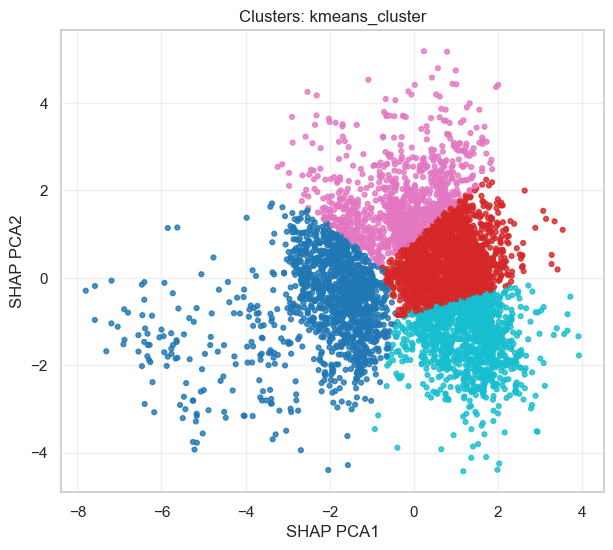

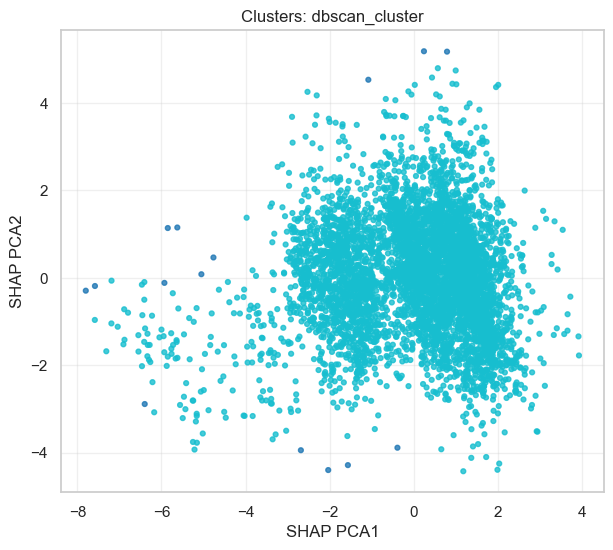

In [68]:
def plot_clusters(embed_df, cluster_col):
    plt.figure(figsize=(7, 6))
    plt.scatter(
        embed_df["shap_pca1"],
        embed_df["shap_pca2"],
        c=embed_df[cluster_col],
        cmap="tab10",
        s=12,
        alpha=0.8
    )
    plt.xlabel("SHAP PCA1")
    plt.ylabel("SHAP PCA2")
    plt.title(f"Clusters: {cluster_col}")
    plt.grid(True, alpha=0.3)
    plt.show()


plot_clusters(embed_df, "kmeans_cluster")
plot_clusters(embed_df, "dbscan_cluster")


In [69]:
final_features = [str(f) for f in final_features]

shap_df = pd.DataFrame(shap_values_boost, columns=final_features)
shap_df.columns = shap_df.columns.astype(str)

y_cv = y_test.reset_index(drop=True)

logreg = LogisticRegression(max_iter=1000, random_state=42)

scores_shap = cross_val_score(logreg, shap_df, y_cv, cv=3, scoring="roc_auc")

print(f"CV ROC-AUC (только SHAP): {scores_shap.mean():.4f} ± {scores_shap.std():.4f}")

X_base = X_test_raw.reset_index(drop=True).copy()
X_base.columns = X_base.columns.astype(str)

X_concat = pd.concat([X_base, shap_df], axis=1)

scores_concat = cross_val_score(logreg, X_concat, y_cv, cv=3, scoring="roc_auc")

print(f"CV ROC-AUC (оригинальные + SHAP): {scores_concat.mean():.4f} ± {scores_concat.std():.4f}")

corr_mat = np.corrcoef(shap_values_boost.T)
G = nx.Graph()

threshold = 0.25  # порог влияния

for i, fi in enumerate(final_features):
    for j in range(i + 1, len(final_features)):
        fj = final_features[j]
        w = abs(corr_mat[i, j])
        if w > threshold:
            G.add_edge(fi, fj, weight=w)

print(f"Рёбер в графе Shapley Flow (|corr|>{threshold}): {G.number_of_edges()}")

# Топ-5 самых сильных связей
edges_sorted = sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:5]

for u, v, d in edges_sorted:
    print(f"{u} - {v}: corr={d['weight']:.3f}")


CV ROC-AUC (только SHAP): 0.6224 ± 0.0367
CV ROC-AUC (оригинальные + SHAP): 0.6251 ± 0.0363
Рёбер в графе Shapley Flow (|corr|>0.25): 8
home_team_home_wr - home_avg_plus_minus_pre: corr=0.795
HOME_TEAM_ID_target_enc - home_team_home_wr: corr=0.751
away_WR_last_season - wr_difference: corr=0.548
HOME_TEAM_ID_target_enc - home_avg_plus_minus_pre: corr=0.545
home_streak - home_last5_wins: corr=0.538


### Итоги третьего чекпоинта (детально)

- SHAP/LIME (LogReg и GB): ключевые признаки совпадают и по направлению влияния - `wr_difference`, `home_last5_wins`, `home_team_home_wr`, target-encoding команд; рост преимуществ дома увеличивает вероятность победы.
- SHAP-эмбеддинг преобразованный к 2D через PCA. DBSCAN выделил один большой кластер с шумом по краям. IsolationForest (5%) показал, что выбросы в тесте почти не влияют на GB, значит шум не критичен.
- Признак `shap_cluster`: добавление кластеров SHAP к логрег повысило ROC-AUC.
- CV: модель только на SHAP-эмбеддингах даёт сопоставимый ROC-AUC; конкатенация исходных признаков и SHAP стабильнее и даёт лучший средний результат.
- Shapley Flow (граф сильных корреляций shap-вкладов, |corr|>0.25): связки `wr_difference` - `away_WR_last_season` - target-encoding команд формируют главный вклад в модель.
- Качество итога этапа: удержан и усилен прирост относительно baseline.


## Доп улучшения и финальные замеры качества

- Добавить метрики из отчетов от экспертных аналитиков NBA

In [70]:
def add_preseason_features(extended_games, games_df, teams_df, ranking_df):
    # создаем копию
    df = extended_games.copy()

    season_stats = {}

    for season in sorted(df['SEASON'].unique()):
        prev_season = season - 1

        prev_season_games = games_df[games_df['SEASON'] == prev_season].copy()

        if len(prev_season_games) == 0:
            continue

        for team_id in df['HOME_TEAM_ID'].unique():
            # home
            home_games = prev_season_games[prev_season_games['HOME_TEAM_ID'] == team_id]
            # away
            away_games = prev_season_games[prev_season_games['VISITOR_TEAM_ID'] == team_id]

            total_games = len(home_games) + len(away_games)

            if total_games == 0:
                continue

            home_wins = home_games['HOME_TEAM_WINS'].sum() if len(home_games) > 0 else 0
            away_wins = len(away_games) - away_games['HOME_TEAM_WINS'].sum() if len(away_games) > 0 else 0
            total_wins = home_wins + away_wins
            win_pct = total_wins / total_games

            home_point_diff = (home_games['PTS_home'] - home_games['PTS_away']).mean() if len(home_games) > 0 else 0
            away_point_diff = (away_games['PTS_away'] - away_games['PTS_home']).mean() if len(away_games) > 0 else 0

            if len(home_games) > 0 or len(away_games) > 0:
                net_rating = (home_point_diff * len(home_games) + away_point_diff * len(away_games)) / total_games
            else:
                net_rating = 0

            season_stats[(team_id, season)] = {
                'prev_season_win_pct': win_pct,
                'prev_season_net_rating': net_rating
            }

    home_win_pct = []
    away_win_pct = []
    home_net_rating = []
    away_net_rating = []

    for idx, row in df.iterrows():
        home_key = (row['HOME_TEAM_ID'], row['SEASON'])
        away_key = (row['VISITOR_TEAM_ID'], row['SEASON'])

        if home_key in season_stats:
            home_win_pct.append(season_stats[home_key]['prev_season_win_pct'])
            home_net_rating.append(season_stats[home_key]['prev_season_net_rating'])
        else:
            home_win_pct.append(0.5)
            home_net_rating.append(0)

        if away_key in season_stats:
            away_win_pct.append(season_stats[away_key]['prev_season_win_pct'])
            away_net_rating.append(season_stats[away_key]['prev_season_net_rating'])
        else:
            away_win_pct.append(0.5)
            away_net_rating.append(0)

    #добавялем признаки
    df['home_prev_season_win_pct'] = home_win_pct
    df['away_prev_season_win_pct'] = away_win_pct
    df['home_prev_season_net_rating'] = home_net_rating
    df['away_prev_season_net_rating'] = away_net_rating

    df['prev_win_pct_diff'] = df['home_prev_season_win_pct'] - df['away_prev_season_win_pct']
    df['prev_net_rating_diff'] = df['home_prev_season_net_rating'] - df['away_prev_season_net_rating']

    return df

extended_games = add_preseason_features(extended_games, games_df, teams_df, ranking_df)


In [80]:
feature_df_pre = add_preseason_features(extended_games, games_df, teams_df, ranking_df)

baseline_features = [
    'home_WR_last_season', 'away_WR_last_season',
    'home_avg_plus_minus_pre', 'away_avg_plus_minus_pre',
    'home_comments_last3', 'away_comments_last3'
]

baseline_plus_preseason = baseline_features

data = feature_df_pre[baseline_plus_preseason + ['HOME_TEAM_WINS']].dropna()
split = int(len(data) * 0.8)

results.append(evaluate_model(
    data[baseline_plus_preseason].iloc[:split],
    data['HOME_TEAM_WINS'].iloc[:split],
    data[baseline_plus_preseason].iloc[split:],
    data['HOME_TEAM_WINS'].iloc[split:],
    f"Baseline + Preseason ({len(baseline_plus_preseason)})"
))
results_df = pd.DataFrame(results)
print(results_df.round(4))


                      model  accuracy  precision  recall      f1  roc_auc
0     Baseline (6 features)    0.5890     0.5941  0.8186  0.6885   0.6037
1         All Features (23)    0.5978     0.6081  0.7744  0.6812   0.6288
2    Selected Features (18)    0.5971     0.6067  0.7789  0.6821   0.6290
3  Baseline + Preseason (6)    0.5898     0.5952  0.8192  0.6895   0.6036


Значимых улучшений не выявлено. Либо какая-то ошибка существует, либо все же статистики в нашем случае не особо срабатывают